In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap03/'
OutputDir    = '3LassoLarsIC-0805Polynomial/'
FileBaseName = '3LassoLarsIC-0805Polynomial'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/


* 多項式回帰を線形モデル
$$
y_{m}
=
a_{0}
+
\sum_{n=1}^{N}
a_n
x_m^n
$$

* $\boldsymbol{\omega}=(a_1, \cdots, a_n, \cdots, a_N)$
* 計画行列 $\boldsymbol{X}$

$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

* 線形写像
$$
\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_{0},
$$
$$
\left(
  \begin{array}{c}
  y_1\\
  \vdots \\
  y_m \\
  \vdots \\
  y_M
  \end{array}
\right)
=
\left(
  \begin{array}{c}
  a_0\\
  \vdots \\
  a_0 \\
  \vdots \\
  a_0
  \end{array}
\right)
+
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
\left(
  \begin{array}{c}
  a_1\\
  \vdots \\
  a_n \\
  \vdots \\
  a_N
  \end{array}
\right)
$$

真値を準備する
* $K=11$とする。
* $a_0=0.2,\,a_1=1.0,\,a_2=0.2,\,a_3=-0.3$ として、それ以外は0とする。
$$
y=0.2+1.0x+0.2x^2-0.3x^3
$$

In [4]:
############################################
# y=0.2+1.0X+0.2X^{2}-0.3X^{3}
#
a_0 = 0.25
#
w_K = 11 - 1
#
w_true = np.zeros((w_K,))
# a_1
w_true[0] = 1.0
# a_2
w_true[1] = 0.2
# a_3
w_true[2] = -0.3
#
print(w_true)

[ 1.   0.2 -0.3  0.   0.   0.   0.   0.   0.   0. ]


切片項と $\omega$ の説明変数スペクトルを描くための準備

In [5]:
###########################################
wspec_x = np.linspace( 0, len(w_true), num=1+len(w_true))
#
# 切片項を先頭に追加
wspec_true = np.concatenate( [[a_0], w_true] )
#
# 1: scrue = np.concatenate( [[a_0], w_true] )
#
# 1: scatter
# 0: vlines
wspec_true_set = [ wspec_true, 1, r'$a_{0}, \vec{\omega}_{\rm true}$', 'red' ]
###########################################

切片項と $\omega$ の説明変数スペクトルを描く関数

In [6]:
###########################################
def SubGrf_wspec( axis, wspec_sets_, title=None ):
  #
  axis.set_xlabel( 'Order' )
  #
  axis.set_ylabel( r'$a_{0}, \vec{\omega}$' )
  #
  int_max = None
  int_min = None
  #
  for wspec_set_ in wspec_sets_:
    #
    wspec_ = wspec_set_[0]
    mode_  = wspec_set_[1] # 0=vlines, 1=scatter
    label_ = wspec_set_[2]
    #
    color_ = wspec_set_[3]
    #
    #######
    L0_ = np.count_nonzero( wspec_ )
    label_ = label_  + r' ($L_{0}$=%d)' % L0_
    #
    #######
    wspec_max = np.amax( wspec_ )
    wspec_min = np.amin( wspec_ )
    #
    #######
    if int_max is not None:
      if wspec_max > int_max:
        int_max = wspec_max
    else:
      int_max = wspec_max
    #
    if int_min is not None:
      if wspec_min < int_min:
        int_min = wspec_min
    else:
      int_min = wspec_min
    #
    #######
    if mode_ == 0:
      # 0: vlines
      axis.vlines( wspec_x, 0, wspec_, label=label_, colors=color_, linewidth=3, linestyles='solid' )
    else:
      # 1: scatter
      axis.scatter( wspec_x, wspec_, label=label_, color=color_, s=30, marker='o' )
    #
    #######
    int_center = (int_max + int_min)/2.0
    int_width  = (int_max - int_min)/2.0
    axis.set_ylim( int_center - 1.2 * int_width, int_center + 1.2 * int_width )
    #
  #
  # zero
  axis.axhline( 0.0, color='black', linewidth=0.5, linestyle='dotted' )
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return
###########################################
def Grf_wspec( wspec_sets_, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_wspec( ax1, wspec_sets_, title=title )
  #
  plt.show()
  #
  return fig

解析データの準備
* データ点数: $M=51$
* $x$値の範囲: $x=[-2.0, +2.0]$

In [7]:
############################################
M = 51 # 201
#
x = np.linspace(-2.0,+2.0, num=M, endpoint=True)
#
print(x)

[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


計画行列$X$の準備
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

In [8]:
############################################
X = np.zeros((M, w_K))
#
for k in range(w_K):
    X[:,k] = x**(k+1)
#
print(X)

[[-2.00000000e+00  4.00000000e+00 -8.00000000e+00  1.60000000e+01
  -3.20000000e+01  6.40000000e+01 -1.28000000e+02  2.56000000e+02
  -5.12000000e+02  1.02400000e+03]
 [-1.92000000e+00  3.68640000e+00 -7.07788800e+00  1.35895450e+01
  -2.60919263e+01  5.00964985e+01 -9.61852772e+01  1.84675732e+02
  -3.54577406e+02  6.80788619e+02]
 [-1.84000000e+00  3.38560000e+00 -6.22950400e+00  1.14622874e+01
  -2.10906087e+01  3.88067201e+01 -7.14043650e+01  1.31384032e+02
  -2.41746618e+02  4.44813777e+02]
 [-1.76000000e+00  3.09760000e+00 -5.45177600e+00  9.59512576e+00
  -1.68874213e+01  2.97218616e+01 -5.23104763e+01  9.20664384e+01
  -1.62036931e+02  2.85184999e+02]
 [-1.68000000e+00  2.82240000e+00 -4.74163200e+00  7.96594176e+00
  -1.33827822e+01  2.24830740e+01 -3.77715644e+01  6.34562281e+01
  -1.06606463e+02  1.79098858e+02]
 [-1.60000000e+00  2.56000000e+00 -4.09600000e+00  6.55360000e+00
  -1.04857600e+01  1.67772160e+01 -2.68435456e+01  4.29496730e+01
  -6.87194767e+01  1.09951163e+02

真値データの準備。
$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

In [9]:
############################################
y_true = X @ w_true + a_0
#
print(y_true)

[ 1.45       1.1906464  0.9559712  0.7450528  0.5569696  0.3908
  0.2456224  0.1205152  0.0145568 -0.0731744 -0.1436    -0.1976416
 -0.2362208 -0.2602592 -0.2706784 -0.2684    -0.2543456 -0.2294368
 -0.1945952 -0.1507424 -0.0988    -0.0396896  0.0256672  0.0963488
  0.1714336  0.25       0.3311264  0.4138912  0.4973728  0.5806496
  0.6628     0.7429024  0.8200352  0.8932768  0.9617056  1.0244
  1.0804384  1.1288992  1.1688608  1.1994016  1.2196     1.2285344
  1.2252832  1.2089248  1.1785376  1.1332     1.0719904  0.9939872
  0.8982688  0.7839136  0.65     ]


誤差を重畳させたデータの準備。
* $\boldsymbol{y}_1=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{1});\;(\sigma_{1}=3.0\times10^{-1})$

In [10]:
############################################
rd.seed(89218)# デモデータなので、同じ結果になるように乱数のシードを設定
############################################
noise = rd.randn(M).reshape(M,)
# ノイズの平均値を0、標準偏差を1に規格化
noise = noise - np.mean( noise )
noise = noise / np.std( noise )
y_1 = y_true + 3.0E-1 * noise # 1.0E-1 * noise

計画行列$X$を標準化する
* 元行列:
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots & X_{1n} & \cdots & X_{1N} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots & X_{mn} & \cdots & X_{mN} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots & X_{Mn} & \cdots & X_{MN}
  \end{array}
\right)
$$

* 標準化
```
scalerX = prep.StandardScaler()
scalerX.fit( X )
X_ss = scalerX.transform( X )
```
$$
\tilde{X_{mn}}=\frac{
  X_{mn}-\mu_n
}{
  s_n
}
$$

1. $\mu_n$:  scalerX.mean_[n]
$$
\boldsymbol{\mu}
=
\left(
  \begin{array}{c}
    \mu_{1} \\
    \vdots  \\
    \mu_{n} \\
    \vdots  \\
    \mu_{N}
  \end{array}
\right)
$$

2. $s_n$:    scalerX.scale_[n]

$$
\boldsymbol{s}
=
\left(
  \begin{array}{c}
    s_{1} \\
    \vdots  \\
    s_{n} \\
    \vdots  \\
    s_{N}
  \end{array}
\right)
,
\quad
\boldsymbol{s'}
=
\left(
  \begin{array}{c}
    \frac{1}{s_{1}} \\
    \vdots  \\
    \frac{1}{s_{n}} \\
    \vdots  \\
    \frac{1}{s_{N}}
  \end{array}
\right)
$$

* 標準化された行列:
$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \tilde{X_{11}} & \cdots & \tilde{X_{1n}} & \cdots & \tilde{X_{1N}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{m1}} & \cdots & \tilde{X_{mn}} & \cdots & \tilde{X_{mN}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{M1}} & \cdots & \tilde{X_{Mn}} & \cdots & \tilde{X_{MN}}
  \end{array}
\right)
$$
1. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の平均値が0
2. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の標準偏差が1

に標準化される。

$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
$$


* 標準化していない$\boldsymbol{X}$と切片項$a_0$を用いると、

$$\boldsymbol{y}\approx\boldsymbol{X}\boldsymbol{\omega}+a_0$$

* $\tilde{\boldsymbol{X}}$を使って得られた解を$\hat{\tilde{\boldsymbol{\omega}}}$、切片項を$\hat{a}_0$とする。

$$\boldsymbol{y}\approx\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}+\hat{a}_0$$

$$
\left(
  \begin{array}{c}
    y_{1} - \hat{a}_0 \\
    \vdots            \\
    y_{m} - \hat{a}_0 \\
    \vdots            \\
    y_{M} - \hat{a}_0
  \end{array}
\right)
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \hat{\tilde{\omega}}_{1} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{n} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{N}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11}-\mu_1 & \cdots &
  X_{1n}-\mu_n & \cdots &
  X_{1N}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1}-\mu_1 & \cdots &
  X_{mn}-\mu_n & \cdots &
  X_{mN}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1}-\mu_1 & \cdots &
  X_{Mn}-\mu_n & \cdots &
  X_{MN}-\mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots &
  X_{1n} & \cdots &
  X_{1N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots &
  X_{mn} & \cdots &
  X_{mN}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots &
  X_{Mn} & \cdots &
  X_{MN}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
-
\left(
  \begin{array}{ccccc}
  \mu_1 & \cdots &
  \mu_n & \cdots &
  \mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

よって、

$$
\boldsymbol{y}-\hat{a}_0
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
$$

$$
\therefore\,\,\,
\boldsymbol{y}
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+\hat{a}_0
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
+
\hat{a}_0
$$

一方

$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

なので、

$$\boldsymbol{\omega}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
$$

$$a_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
$$

ここで、$\circ$はアダマール積(Hadamard product)である。

In [11]:
############################################
scalerX = prep.StandardScaler()
scalerX.fit( X )
#
X_ss = scalerX.transform( X )
#
mu_vec     = scalerX.mean_
sdash_vec  = 1 / scalerX.scale_

yデータを描くグラフ

In [12]:
############################################
def SubGrf_ydata( axis, x_data, y_sets, title=None ):
  #
  x_left, x_right = axis.set_xlim( -2.2, 2.2 )
  axis.set_xlabel( r'$x$' )
  #
  y_bot, y_top = axis.set_ylim( -1.5, 2.0 )
  axis.set_ylabel( r'$y$' )
  #
  for y_set in y_sets:
    # [y_data, plottype, label, 'color', size/linewidth, marker/linestyle]
    #   plottype = 0 -> plot
    #   plottype = 1 -> scatter
    if   y_set[1] == 0:
      #
      axis.plot( x_data, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1] == 1:
      #
      axis.scatter( x_data, y_set[0], label=y_set[2], color=y_set[3], s=y_set[4], marker=y_set[5] )
      #
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return
############################################
def Grf_ydata( x_data, y_sets, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_ydata( ax1, x_data, y_sets, title )
  #
  plt.show()
  #
  return fig

In [13]:
############################################
y_target   = y_1
#
y_true_set   = [ y_true,    0, r'$\vec{y}_{\rm true}$',   'red',   2, 'solid' ]
y_target_set = [ y_target,  1, r'$\vec{y}_{\rm target}$', 'blue', 10, 'o'     ]
#
# ############################################
# y_sets     = [ y_true_set, y_target_set ]
# fig = Grf_ydata( x, y_sets )
# #
# fig.savefig( FilePath + FileBaseName + '-y_target.pdf' )

回帰係数 $\hat{\boldsymbol{\omega}}$ と、Criterionsを描画するグラフ関数

In [14]:
############################################
def SubGrf_omega_Criterions( axis, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None, title_=None ):
  #
  #############
  # omega
  omegas_max = np.amax( np.abs( omegas_ ) )
  #
  axis.set_xscale( 'log' )
  axis.set_xlabel( r'$\alpha$' )
  #
  axis.set_ylabel( r'$\hat{\omega}$' )
  axis.set_ylim( -1.4 * omegas_max, 1.4 * omegas_max )
  #
  axis.plot( alphas_, omegas_ , zorder=0.2)
  axis.plot( alphas_, a0s_, linestyle='dashed', color='gray', zorder=0.3 )
  #
  alphas_left, alphas_right = axis.set_xlim()
  #
  #########
  # True
  # a_0
  axis.axhline( y = a_0, linestyle='dotted', color='gray', zorder=0.1 )
  #
  # w_true
  for w_val in w_true:
    if w_val != 0.0:
      axis.axhline( y = w_val, linestyle='dotted', color='black', zorder=0.1 )
  #
  #########
  idx_a_ = None
  #########
  if idx_ is not None:
    idx_a_  = alphas_[ idx_ ]
    idx_L0_ = L0s_[ idx_ ]
    #
    if IC_idx_ is not None:
      if IC_idx_ == idx_:
        idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
      else:
        idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
    #
  elif IC_idx_ is not None:
    idx_a_  = alphas_[ IC_idx_ ]
    idx_L0_ = L0s_[ IC_idx_ ]
    #
    idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #
  if idx_a_ is not None:
    # 0の場合がある
    if idx_a_ > 0:
      idx_a_mark_ = idx_a_
    else:
      idx_a_mark_ = alphas_left
    #
    axis.axvline( idx_a_mark_, color='gray', linestyle='dashed',zorder=1.0 )
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    axis.text( idx_a_mark_, axis_bot + 0.05*(axis_top-axis_bot),
               idx_text, fontsize=12, rotation=90,
               horizontalalignment='center', verticalalignment='bottom',
               color='white', backgroundcolor='gray', zorder=2.0)
  #
  #############
  # Criterions
  axC = axis.twinx()
  axC.set_ylabel( 'Criterion', color='black' )
  #
  Criterions_max = None
  Criterions_min = None
  #
  for Criterion_set_ in Criterion_sets_:
    #
    label_            = Criterion_set_[0]
    Criterion_type_   = Criterion_set_[1]
    Criterion_data_   = Criterion_set_[2]
    Criterion_color_  = Criterion_set_[3]
    #
    c_max_ = np.amax( Criterion_data_ )
    c_min_ = np.amin( Criterion_data_ )
    #
    if Criterions_max is None:
      Criterions_max = c_max_
    else:
      if c_max_ > Criterions_max:
        Criterions_max = c_max_
    #
    if Criterions_min is None:
      Criterions_min = c_min_
    else:
      if c_min_ < Criterions_min:
        Criterions_min = c_min_
    #
    if Criterion_type_ == 0:  #line
      axC.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linewidth=3)
    elif Criterion_type_ == 1:
      axC.scatter( alphas_, Criterion_data_, label=label_, color=Criterion_color_, s=10)
    elif Criterion_type_ == 2:
      axC.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linestyle='dashed', linewidth=3)
  #
  Criterions_center = (Criterions_max + Criterions_min)/2
  Criterions_width  = (Criterions_max - Criterions_min)/2
  #
  axC.set_ylim( Criterions_center-1.1*Criterions_width, Criterions_center+1.4*Criterions_width )
  #
  plt.legend(loc='upper right', fontsize=12)
  #
  if title_ is None:
    title_ = IC_upper + r': $\hat{\omega}$, Criterion'
  #
  plt.title( title_ )
  #
  return
############################################
def Grf_omega_Criterions( alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None  ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure( figsize=(5.5, 5) )
  fig.subplots_adjust(left=0.15, right=0.77, top=0.93, bottom=0.13)
  #
  axis = fig.add_subplot(1,1,1)
  #
  SubGrf_omega_Criterions( axis, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=idx_, IC_idx_=IC_idx_ )
  #
  plt.show()
  #
  return fig

情報量規準の確認結果で、指定したidxの結果のグラフを出力する関数

In [15]:
############################################
def Grf_ICsurveySummary( dictICsurvey_, idx_=None ):
  #
  ##########################################
  IC_upper_ = dictICsurvey_[ 'IC_upper' ]
  L0s_      = dictICsurvey_[ 'L0_s' ]
  # 'L0_a0_s', 'L0_w_s',
  w_org_s_  = dictICsurvey_[ 'w_org_s' ]
  a0_org_s_ = dictICsurvey_[ 'a0_org_s' ]
  # 'yreg_s',
  # 'yreg_RMSD_target_s',
  # 'yreg_RMSD_true_s',
  # 'wspec_RMSD_true_s',
  IC_0_s_     = dictICsurvey_[ 'IC_0_s' ]
  IC_1_s_     = dictICsurvey_[ 'IC_1_s' ]
  IC_2_s_     = dictICsurvey_[ 'IC_2_s' ]
  # 'IC_check_s',
  alphas_     = dictICsurvey_[ 'alphas'     ]
  IC_alpha_   = dictICsurvey_[ 'IC_alpha'   ]
  IC_idx_     = dictICsurvey_[ 'IC_idx'     ]
  criterions_ = dictICsurvey_[ 'criterions' ]
  #
  ##########################################
  if idx_ is None:
    idx_ = np.where( alphas_ == IC_alpha_ )[0][0]
  #
  a_      = dictICsurvey_[ 'alphas'   ][ idx_ ]
  yreg_   = dictICsurvey_[ 'yreg_s'   ][ idx_ ]
  w_org_  = dictICsurvey_[ 'w_org_s'  ][ idx_ ]
  a0_org_ = dictICsurvey_[ 'a0_org_s' ][ idx_ ]
  #
  ##########################################
  # Graph
  ##########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.94, top=0.91, bottom=0.12, wspace=0.27)
  #
  ###########
  y_true_set   = [ y_true,   0, r'$\vec{y}_{\rm true}$',   'red',   2, 'dashed' ]
  y_target_set = [ y_target, 1, r'$\vec{y}_{\rm target}$', 'blue', 10, 'o'      ]
  y_reg_set    = [ yreg_,    0, r'$\hat{\vec{y}}$',        'green', 3, 'solid'  ]
  #
  y_sets    = [ y_true_set, y_target_set, y_reg_set ]
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  #
  title1 = r'(a) $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  SubGrf_ydata( ax_y, x, y_sets, title=title1 )
  #
  ###########
  wspec_true_set   = [ wspec_true, 1, r'$a_{\rm 0, true}, \vec{\omega}_{\rm true}$', 'red' ]
  wspec_reg_       = np.concatenate( [[a0_org_], w_org_] )
  wspec_reg_label_ = r'$a_{0}, \vec{\omega}$'
  wspec_reg_set    = [ wspec_reg_, 0, wspec_reg_label_, 'green' ]
  #
  wspec_sets = [ wspec_true_set, wspec_reg_set ]
  ###########
  ax_wspec = fig.add_subplot(1, 3, 2)
  #
  title2 = r'(b) $\vec{\omega}_{\rm true}, \hat{\vec{\omega}}(\alpha=$%.2E$)$' % a_
  SubGrf_wspec( ax_wspec, wspec_sets, title=title2 )
  #
  ###########
  Criterion_sets = [ [ IC_upper,          0, criterions_, 'red'   ],
                     [ r'${\rm IC}_{1}$', 2, IC_0_s_,     'black' ],
                     [ r'${\rm IC}_{2}$', 2, IC_1_s_,     'green' ],
                     [ r'${\rm IC}_{3}$', 2, IC_2_s_,     'orange'] ]
  ###########
  ax_summary = fig.add_subplot(1, 3, 3)
  #
  title3 = '(c) ' + IC_upper_ + r': $\hat{\omega}$, Criterions'
  SubGrf_omega_Criterions( ax_summary, alphas_, w_org_s_, a0_org_s_, L0s_, Criterion_sets, idx_=idx_, IC_idx_=IC_idx_, title_=title3 )
  #
  ###########
  plt.show()
  ###########
  return fig

path図を省略した図

In [16]:
############################################
def SubGrf_omega_Criterions_v2( axis, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None, title_=None ):
  #
  # #############
  # # omega
  # omegas_max = np.amax( np.abs( omegas_ ) )
  # #
  axis.set_xscale( 'log' )
  axis.set_xlabel( r'$\alpha$' )
  # #
  # axis.set_ylabel( r'$\hat{\omega}$' )
  # axis.set_ylim( -1.4 * omegas_max, 1.4 * omegas_max )
  # #
  # axis.plot( alphas_, omegas_ , zorder=0.2)
  # axis.plot( alphas_, a0s_, linestyle='dashed', color='gray', zorder=0.3 )
  # #
  # alphas_left, alphas_right = axis.set_xlim()
  # #
  # #########
  # # True
  # # a_0
  # axis.axhline( y = a_0, linestyle='dotted', color='gray', zorder=0.1 )
  # #
  # # w_true
  # for w_val in w_true:
  #   if w_val != 0.0:
  #     axis.axhline( y = w_val, linestyle='dotted', color='black', zorder=0.1 )
  # #
  # #########
  # idx_a_ = None
  # #########
  # if idx_ is not None:
  #   idx_a_  = alphas_[ idx_ ]
  #   idx_L0_ = L0s_[ idx_ ]
  #   #
  #   if IC_idx_ is not None:
  #     if IC_idx_ == idx_:
  #       idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #     else:
  #       idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #   #
  # elif IC_idx_ is not None:
  #   idx_a_  = alphas_[ IC_idx_ ]
  #   idx_L0_ = L0s_[ IC_idx_ ]
  #   #
  #   idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  # #
  # if idx_a_ is not None:
  #   # 0の場合がある
  #   if idx_a_ > 0:
  #     idx_a_mark_ = idx_a_
  #   else:
  #     idx_a_mark_ = alphas_left
  #   #
  #   axis.axvline( idx_a_mark_, color='gray', linestyle='dashed',zorder=1.0 )
  #   #
  #   (axis_bot, axis_top) = axis.set_ylim()
  #   #
  #   axis.text( idx_a_mark_, axis_bot + 0.05*(axis_top-axis_bot),
  #              idx_text, fontsize=12, rotation=90,
  #              horizontalalignment='center', verticalalignment='bottom',
  #              color='white', backgroundcolor='gray', zorder=2.0)
  #
  #############
  # Criterions
  # axC = axis.twinx()
  axis.set_ylabel( 'Criterion', color='black' )
  #
  Criterions_max = None
  Criterions_min = None
  #
  for Criterion_set_ in Criterion_sets_:
    #
    label_            = Criterion_set_[0]
    Criterion_type_   = Criterion_set_[1]
    Criterion_data_   = Criterion_set_[2]
    Criterion_color_  = Criterion_set_[3]
    #
    c_max_ = np.amax( Criterion_data_ )
    c_min_ = np.amin( Criterion_data_ )
    #
    if Criterions_max is None:
      Criterions_max = c_max_
    else:
      if c_max_ > Criterions_max:
        Criterions_max = c_max_
    #
    if Criterions_min is None:
      Criterions_min = c_min_
    else:
      if c_min_ < Criterions_min:
        Criterions_min = c_min_
    #
    if Criterion_type_ == 0:  #line
      axis.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linewidth=3)
    elif Criterion_type_ == 1:
      axis.scatter( alphas_, Criterion_data_, label=label_, color=Criterion_color_, s=10)
    elif Criterion_type_ == 2:
      axis.plot( alphas_, Criterion_data_, label=label_, color=Criterion_color_, linestyle='dashed', linewidth=3)
  #
  Criterions_center = (Criterions_max + Criterions_min)/2
  Criterions_width  = (Criterions_max - Criterions_min)/2
  #
  axis.set_ylim( Criterions_center-1.1*Criterions_width, Criterions_center+1.4*Criterions_width )
  #
  #########
  idx_a_ = None
  #########
  if idx_ is not None:
    idx_a_  = alphas_[ idx_ ]
    idx_L0_ = L0s_[ idx_ ]
    #
    if IC_idx_ is not None:
      if IC_idx_ == idx_:
        idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
      else:
        idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
    #
  elif IC_idx_ is not None:
    idx_a_  = alphas_[ IC_idx_ ]
    idx_L0_ = L0s_[ IC_idx_ ]
    #
    idx_text = r'(*) $\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
  #
  if idx_a_ is not None:
    # 0の場合がある
    if idx_a_ > 0:
      idx_a_mark_ = idx_a_
    else:
      idx_a_mark_ = alphas_left
    #
    axis.axvline( idx_a_mark_, color='gray', linestyle='dashed',zorder=1.0 )
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    # axis.text( idx_a_mark_, axis_bot + 0.05*(axis_top-axis_bot),
    axis.text( idx_a_mark_, axis_bot + 0.4*(axis_top-axis_bot),
               idx_text, fontsize=12, rotation=90,
               horizontalalignment='center', verticalalignment='bottom',
               color='white', backgroundcolor='gray', zorder=2.0)
  #
  # plt.legend(loc='upper right', fontsize=12)
  plt.legend(loc='upper left', fontsize=12)
  #
  if title_ is None:
    title_ = IC_upper + r': $\hat{\omega}$, Criterion'
  #
  plt.title( title_ )
  #
  return
############################################
def Grf_omega_Criterions_v2( alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=None, IC_idx_=None  ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure( figsize=(5.5, 5) )
  fig.subplots_adjust(left=0.15, right=0.77, top=0.93, bottom=0.13)
  #
  axis = fig.add_subplot(1,1,1)
  #
  SubGrf_omega_Criterions_v2( axis, alphas_, omegas_, a0s_, L0s_, Criterion_sets_, idx_=idx_, IC_idx_=IC_idx_ )
  #
  plt.show()
  #
  return fig

In [17]:
############################################
def Grf_ICsurveySummary_v2( dictICsurvey_, idx_=None ):
  #
  ##########################################
  IC_upper_ = dictICsurvey_[ 'IC_upper' ]
  L0s_      = dictICsurvey_[ 'L0_s' ]
  # 'L0_a0_s', 'L0_w_s',
  w_org_s_  = dictICsurvey_[ 'w_org_s' ]
  a0_org_s_ = dictICsurvey_[ 'a0_org_s' ]
  # 'yreg_s',
  # 'yreg_RMSD_target_s',
  # 'yreg_RMSD_true_s',
  # 'wspec_RMSD_true_s',
  IC_0_s_     = dictICsurvey_[ 'IC_0_s' ]
  IC_1_s_     = dictICsurvey_[ 'IC_1_s' ]
  IC_2_s_     = dictICsurvey_[ 'IC_2_s' ]
  # 'IC_check_s',
  alphas_     = dictICsurvey_[ 'alphas'     ]
  IC_alpha_   = dictICsurvey_[ 'IC_alpha'   ]
  IC_idx_     = dictICsurvey_[ 'IC_idx'     ]
  criterions_ = dictICsurvey_[ 'criterions' ]
  #
  ##########################################
  if idx_ is None:
    idx_ = np.where( alphas_ == IC_alpha_ )[0][0]
  #
  a_      = dictICsurvey_[ 'alphas'   ][ idx_ ]
  yreg_   = dictICsurvey_[ 'yreg_s'   ][ idx_ ]
  w_org_  = dictICsurvey_[ 'w_org_s'  ][ idx_ ]
  a0_org_ = dictICsurvey_[ 'a0_org_s' ][ idx_ ]
  #
  ##########################################
  # Graph
  ##########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.94, top=0.91, bottom=0.12, wspace=0.27)
  #
  ###########
  y_true_set   = [ y_true,   0, r'$\vec{y}_{\rm true}$',   'red',   2, 'dashed' ]
  y_target_set = [ y_target, 1, r'$\vec{y}_{\rm target}$', 'blue', 10, 'o'      ]
  y_reg_set    = [ yreg_,    0, r'$\hat{\vec{y}}$',        'green', 3, 'solid'  ]
  #
  y_sets    = [ y_true_set, y_target_set, y_reg_set ]
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  #
  title1 = r'(a) $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  SubGrf_ydata( ax_y, x, y_sets, title=title1 )
  #
  ###########
  wspec_true_set   = [ wspec_true, 1, r'$a_{\rm 0, true}, \vec{\omega}_{\rm true}$', 'red' ]
  wspec_reg_       = np.concatenate( [[a0_org_], w_org_] )
  wspec_reg_label_ = r'$a_{0}, \vec{\omega}$'
  wspec_reg_set    = [ wspec_reg_, 0, wspec_reg_label_, 'green' ]
  #
  wspec_sets = [ wspec_true_set, wspec_reg_set ]
  ###########
  ax_wspec = fig.add_subplot(1, 3, 2)
  #
  title2 = r'(b) $\vec{\omega}_{\rm true}, \hat{\vec{\omega}}(\alpha=$%.2E$)$' % a_
  SubGrf_wspec( ax_wspec, wspec_sets, title=title2 )
  #
  ###########
  Criterion_sets = [ [ IC_upper,          0, criterions_, 'red'   ],
                     [ r'${\rm IC}_{1}$', 2, IC_0_s_,     'black' ],
                     [ r'${\rm IC}_{2}$', 2, IC_1_s_,     'green' ],
                     [ r'${\rm IC}_{3}$', 2, IC_2_s_,     'orange'] ]
  ###########
  ax_summary = fig.add_subplot(1, 3, 3)
  #
  title3 = '(c) ' + IC_upper_ + r': $\hat{\omega}$, Criterions'
  SubGrf_omega_Criterions_v2( ax_summary, alphas_, w_org_s_, a0_org_s_, L0s_, Criterion_sets, idx_=idx_, IC_idx_=IC_idx_, title_=title3 )
  #
  ###########
  plt.show()
  ###########
  return fig

情報量規準 (Information Crieterion)
* 参考文献
  * B. H. Zou, T. Hastie, R. Tibshirani, On The "Degrees of Freedom" of The LASSO", The Annals of Statistics **35**, 2173 (2007). http://dx.doi.org/10.1214/009053607000000127
  * 小西 貞則, 北川 源四郎, 情報量規準 (シリーズ・予測と発見の科学), 朝倉書店 (2004). ISBN-10 : 4254127820
  * 樺島祥介, 北川源四郎, 甘利俊一, 赤池弘次, 下平英寿, 土谷 隆, 室田一雄, 赤池情報量規準AIC―モデリング・予測・知識発見, 共立出版 (2007). ISBN-10 : 4320121902

scikit-learn の LassoLarsIC

* 尤度項

  重畳するノイズが標準偏差 $\sigma_{\rm noise}$の正規分布に従う場合、尤度項$P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})$は

  $$
    P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})
    =
    \left(
      \frac{1}{
        \sigma_{\rm noise}
        \sqrt{2\pi}
      }
    \right)^{M}
    \exp
    \left[
    -
    \frac{
      \left(
        \boldsymbol{y}
        -
        \hat{\boldsymbol{y}}(\hat{\boldsymbol{\omega}})
      \right)^{2}
    }{
      2\sigma_{\rm noise}^{2}
    }
  \right]
  $$

  である。ここで $\boldsymbol{y}$ は $M$ 個の測定値からなる解析対象データベクトル、$\hat{\boldsymbol{y}}$ は、推定された説明変数 $\hat{\boldsymbol{\omega}}$ で得られる推定(再現)データである。よって以下となる。

  $$
    -2\ln[P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})]
    =
    M
    \ln
    \left(
      2\pi
      \sigma_{\rm noise}^{2}
    \right)
    +
    \frac{
      1
    }{
      \sigma_{\rm noise}^{2}
    }
    \sum_{m=1}^{M}
    \left[
      y_m
      -
      \hat{y}_{m}(\hat{\boldsymbol{\omega}})
    \right]^{2}
  $$

* モデルの自由度: $\widehat{df}(\boldsymbol{\omega})$

  * LassoLarsICでは、モデルの自由度として説明変数$\boldsymbol{\omega}$の非ゼロ要素数を採用している。
  $$
   \widehat{df}(\boldsymbol{\omega})
   =
   {\rm L}_{0}(\boldsymbol{\omega})
  $$
  ただしLassoLarsICでは、このモデルの自由度として切片項は含めていない。

* AIC (赤池情報量規準)

  $${\rm AIC}
  =
  -2\ln[P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})]
  +
  2
  \,
  \widehat{df}(\boldsymbol{\omega})
  $$

  重畳するノイズが標準偏差 $\sigma_{\rm noise}$の正規分布に従う場合、次式となる。

  $${\rm AIC}
  =
  \underbrace{
    M
    \ln
    \left(
      2\pi
      \sigma_{\rm noise}^{2}
    \right)
  }_{{\rm IC}_{1}}
  +
  \underbrace{
    \frac{
      1
    }{
      \sigma_{\rm noise}^{2}
    }
    \sum_{m=1}^{M}
    \left[
      y_m
      -
      \hat{y}_{m}(\hat{\boldsymbol{\omega}})
    \right]^{2}  
  }_{{\rm IC}_{2}}
  +
  \underbrace{
    2
    \,
    \widehat{df}(\boldsymbol{\omega})
  }_{{\rm IC}_{3}}
  $$

* BIC (ベイズ情報量規準)

  $${\rm BIC}
  =
  -2\ln[P(\boldsymbol{y}|\hat{\boldsymbol{\omega}})]
  +
  \ln(M)
  \,
  \widehat{df}(\boldsymbol{\omega})
  $$

  重畳するノイズが標準偏差 $\sigma_{\rm noise}$の正規分布に従う場合、次式となる。

  $${\rm BIC}
  =
  \underbrace{
    M
    \ln
    \left(
      2\pi
      \sigma_{\rm noise}^{2}
    \right)
  }_{{\rm IC}_{1}}
  +
  \underbrace{
    \frac{
      1
    }{
      \sigma_{\rm noise}^{2}
    }
    \sum_{m=1}^{M}
    \left[
      y_m
      -
      \hat{y}_{m}(\hat{\boldsymbol{\omega}})
    \right]^{2}  
  }_{{\rm IC}_{2}}
  +
  \underbrace{
    \ln(M)
    \,
    \widehat{df}(\boldsymbol{\omega})
  }_{{\rm IC}_{3}}
  $$

* $\sigma_{\rm noise}^{2}$

  データに重畳する正規分布の分散 $\sigma_{\rm noise}^{2}$ は、一般的には未知である。その場合LassoLarsICでは、
  
  * 説明変数$a_{0}$, $\boldsymbol{\omega}$の解（$\boldsymbol{\omega}_{\rm OLS}$）を、一旦 OLS(一般化最小二乗法)で得て、その再現データ $\check{\boldsymbol{y}}(\boldsymbol{\omega}_{\rm OLS})$ を得る。

  * 説明変数の数 $p$ を、切片項も含めてカウントする。

  これらを用いて $\sigma_{\rm noise}^{2}$ を次式とする。

  $$
  \sigma_{\rm noise}^{2}
  =
  \frac{1}{M-p}
  \sum_{m=1}^{M}
  \left[
    y_m
    -
    \check{y}_{m}(\boldsymbol{\omega}_{\rm OLS})
  \right]^{2}  
  $$

  ただし $M > p$でなければならない。

LassoLarsIC

Larsアルゴリズムを用いたLasso回帰における、情報量規準(BIC/AIC)を用いたモデル選択

$$
\hat{\tilde{\boldsymbol{\omega}}}
=
{\rm arg min}_{\tilde{\boldsymbol{\omega}}}
\left(
  \frac{1}{2M}
  \left\|
    \boldsymbol{y}
    -
    \tilde{\boldsymbol{X}}
    \tilde{\boldsymbol{\omega}}
  \right\|_2^2
  +
  \alpha
  \left\|
    \tilde{\boldsymbol{\omega}}
  \right\|_1
\right)
$$

* sklearn.linear_model.LassoLarsIC
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html
* 引数
  * criterion: 'aic' / 'bic' (default='aic')
  * fit_intercept: 切片を計算するか否か
  * noise_variance: データに重畳する正規分布ノイズの分散 (default=None)。Noneの場合は、内部でOLSによりノイズ分散を推定する。

* 返値
  * coef_: $\hat{\boldsymbol{\omega}}(\alpha_{\rm IC})$の配列, (n_features,)
  * intercept_: 切片値
  * alpha_: 情報量規準で選択された$\alpha_{\rm IC}$
  * alphas_: 計算に用いられた$\alpha$テーブル
  * criterion_: 計算に用いられた各$\alpha$における情報量規準の値
  * noise_variance: 推定(用いた)正規分布ノイズの分散

In [18]:
############################################
# LassoLarsIC を実行する関数
############################################
def dictICriterion( IC_, y_, XX_, fit_intercept=True ):
  #
  ##########################################
  dictIC = {}
  #
  ##########################################
  IC_upper = str.upper( IC_ )
  IC_lower = str.lower( IC_ )
  #
  dictIC[ 'IC_upper' ] = IC_upper
  #
  ##########################################
  print( '-- ' + IC_upper + ' ------------------' )
  #
  ##########################################
  ic_obj = lm.LassoLarsIC( criterion = IC_lower, fit_intercept=fit_intercept )
  ic_obj.fit( XX_, y_ )
  #
  ##########################################
  IC_alpha_      = ic_obj.alpha_
  IC_coef_       = ic_obj.coef_
  IC_intercept_  = ic_obj.intercept_
  IC_noise_var_  = ic_obj.noise_variance_
  #
  dictIC[ 'IC_alpha' ]     = IC_alpha_
  dictIC[ 'IC_coef' ]      = IC_coef_
  dictIC[ 'IC_intercept' ] = IC_intercept_
  dictIC[ 'IC_noise_var' ] = IC_noise_var_
  #
  ##########################################
  print( 'IC_noise_var = ', IC_noise_var_ )
  #
  alphas_        = ic_obj.alphas_
  criterions_    = ic_obj.criterion_
  #
  dictIC[ 'alphas' ]     = alphas_
  dictIC[ 'criterions' ] = criterions_
  #
  ##########################################
  IC_yreg_       = XX_ @ IC_coef_ + IC_intercept_
  IC_yreg_RMSD_  = np.std( IC_yreg_ - y_ )
  #
  dictIC[ 'IC_yreg' ]      = IC_yreg_
  dictIC[ 'IC_yreg_RMSD' ] = IC_yreg_RMSD_
  #
  ##########################################
  #
  if IC_intercept_ != 0:
    IC_L0_intercapt_ = 1
  else:
    IC_L0_intercapt_ = 0
  #
  IC_L0_w = np.count_nonzero( IC_coef_ )
  IC_L0_ = IC_L0_intercapt_ + IC_L0_w
  #
  dictIC[ 'IC_L0' ] = IC_L0_
  #
  ##########################################
  print( '%s : alpha=%.3E : L0=%3d (=%d+%d): RMSD_y=%.3E' % (IC_upper, IC_alpha_, IC_L0_, IC_L0_intercapt_, IC_L0_w, IC_yreg_RMSD_) )
  #
  ##########################################
  IC_coef_org_      = sdash_vec * IC_coef_
  IC_intercept_org_ = IC_intercept_ - mu_vec @ IC_coef_org_
  #
  dictIC[ 'IC_coef_org'      ] = IC_coef_org_
  dictIC[ 'IC_intercept_org' ] = IC_intercept_org_
  #
  ##########################################
  print( 'True:', end='' )
  for val_ in wspec_true:
    print( ' %+.4f :' % val_, end='' )
  #
  print()
  #
  ##########################################
  # w_IC
  IC_wspec = np.concatenate( [[IC_intercept_org_], IC_coef_org_] )
  #
  dictIC[ 'IC_wspec' ] = IC_wspec
  #
  print( '%-4s:' % IC_upper, end='' )
  for val_ in IC_wspec:
    print( ' %+.4f :' % val_, end='' )
  #
  print()
  #
  return dictIC

dictICriterion() の実行経過を元に、情報量規準を確認する関数。

$\alpha$テーブルに従って、LassoLars回帰を繰り返す

$$
\hat{\tilde{\boldsymbol{\omega}}}
=
{\rm arg min}_{\tilde{\boldsymbol{\omega}}}
\left(
  \frac{1}{2M}
  \left\|
    \boldsymbol{y}
    -
    \tilde{\boldsymbol{X}}
    \tilde{\boldsymbol{\omega}}
  \right\|_2^2
  +
  \alpha
  \left\|
    \tilde{\boldsymbol{\omega}}
  \right\|_1
\right)
$$

* $\hat{\tilde{\boldsymbol{\omega}}}$を使った再現データ

$$
\hat{\boldsymbol{y}}
=
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+
\hat{\tilde{a}}_{0}
$$

* 以下の残差を求める

  * $\textrm{RMSD}(\boldsymbol{y} -\hat{\boldsymbol{y}})$ : 解析対象データ(ノイズ重畳)$\boldsymbol{y}$に対する、$\hat{\boldsymbol{y}}$の残差:

  * $\textrm{RMSD}(\boldsymbol{y}_{\rm true} -\hat{\boldsymbol{y}})$ : 真値データ$\boldsymbol{y}_{\rm true}$に対する、$\hat{\boldsymbol{y}}$の残差。但し計測データでは、真値データは不明なので、この残差はわからない。

* 標準化して得られた $\hat{\tilde{\boldsymbol{\omega}}}$, $\hat{\tilde{a}_{0}}$ を $\hat{\boldsymbol{\omega}}$, $\hat{a_{0}}$に戻す

  $$\hat{\boldsymbol{\omega}}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  $$

  $$\hat{a}_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
  $$

  * $\textrm{RMSD}(\boldsymbol{\omega}_{\rm true} -\hat{\boldsymbol{\omega}})$ : 真値の$\boldsymbol{\omega}_{\rm true}$に対する$\hat{\boldsymbol{\omega}}$ の残差。但し計測データでは、真値データは不明なので、この残差はわからない。

In [19]:
############################################
def dictICsurvey( dictIC_, y_, XX_, sdash_vec_, mu_vec_, fit_intercept=True ):
  #
  ##########################################
  dictICsurvey_ = {}
  ##########################################
  dictICsurvey_[ 'dictIC' ] = dictIC_
  IC_upper = dictIC_[ 'IC_upper']
  dictICsurvey_[ 'IC_upper' ] = IC_upper
  ##########################################
  # OLSを用いて noise_varianceの推定
  ##########################################
  reg = lm.LinearRegression()
  #
  reg.fit( XX_, y_ )
  #
  OLS_w  = reg.coef_
  OLS_a0 = reg.intercept_
  #
  OLS_p = len( OLS_w )
  if fit_intercept:
    OLS_p = OLS_p + 1
  #
  # 再現データ
  OLS_yreg = X_ss @ OLS_w + OLS_a0
  #
  noise_variance = np.sum( (y_ - OLS_yreg)**2 ) / (M - OLS_p)
  #
  # LassoLarsIC では、これで推定されたものが、noise_variance_として返される
  print( 'noise_variance = %.4E' % noise_variance )
  print( 'IC_noise_var   = %.4E' % dictIC_['IC_noise_var'] )
  #
  ##########################################
  # 各alphaで AIC/BICを検算
  ##########################################
  lars_L0_s     = []
  lars_L0_a0_s  = []
  lars_L0_w_s   = []
  lars_w_org_s  = []
  lars_a0_org_s = []
  lars_yreg_s   = []
  lars_yreg_RMSD_target_s = []
  lars_yreg_RMSD_true_s   = []
  lars_wspec_RMSD_true_s  = []
  IC_0_s =     []
  IC_1_s =     []
  IC_2_s =     []
  IC_check_s = []
  #
  ##########################################
  print( '  %3s: %-10s : %-10s : %-12s : %-10s : %-10s : %-10s : %-10s : %-10s : %-10s : %-10s' %
        ('idx', 'alpha', 'criterion', 'L0', 'RMSDtarget', 'RMSDtrue', 'wRMSDtrue', 'ICcheck', 'IC_0', 'IC_1', 'IC_2' ) )
  ##########################################
  IC_alpha_   = dictIC_[ 'IC_alpha' ]
  alphas_     = dictIC_[ 'alphas' ]
  criterions_ = dictIC_[ 'criterions' ]
  IC_idx_     = None
  #
  for idx in range( len( alphas_ ) ):
    #
    a         = alphas_[ idx ]
    criterion = criterions_[ idx ]
    #
    ########################################
    if a == IC_alpha_ :
      print( '* %3d: %.4E : %.4E ' % (idx, a, criterion), end='' )
      IC_idx_ = idx
    else:
      print( '  %3d: %.4E : %.4E ' % (idx, a, criterion), end='' )
    #
    ########################################
    # Lars
    ########################################
    lars = lm.LassoLars( alpha = a, fit_intercept=fit_intercept )
    lars.fit( XX_, y_ )
    #
    lars_w  = lars.coef_
    lars_a0 = lars.intercept_
    #
    ########################################
    # L0
    if lars_a0 != 0:
      lars_L0_a0 = 1
    else:
      lars_L0_a0 = 0
    #
    lars_L0_w = np.count_nonzero( lars_w )
    lars_L0   = lars_L0_a0 + lars_L0_w
    print( ': %3d (=%d+%3d) ' % (lars_L0, lars_L0_a0, lars_L0_w), end='' )
    #
    lars_L0_a0_s.append( lars_L0_a0 )
    lars_L0_w_s.append( lars_L0_w )
    lars_L0_s.append( lars_L0 )
    #
    ########################################
    # w, a0を元に戻す
    lars_w_org  = sdash_vec_ * lars_w
    lars_a0_org = lars_a0 - mu_vec_ @ lars_w_org
    #
    lars_w_org_s.append( lars_w_org )
    lars_a0_org_s.append( lars_a0_org )
    #
    ########################################
    # 再現データ
    lars_yreg = XX_ @ lars_w + lars_a0
    #
    lars_yreg_s.append( lars_yreg )
    #
    ########################################
    # 再現データのRMSD
    lars_yreg_RMSD_target = np.std( (y_ - lars_yreg) )
    lars_yreg_RMSD_true   = np.std( (y_true   - lars_yreg) )
    print( ': %.4E : %.4E ' % (lars_yreg_RMSD_target, lars_yreg_RMSD_true), end='' )
    #
    lars_yreg_RMSD_target_s.append( lars_yreg_RMSD_target )
    lars_yreg_RMSD_true_s.append( lars_yreg_RMSD_true )
    #
    ########################################
    lars_wspec  = np.concatenate( [[lars_a0_org], lars_w_org] )
    #
    lars_wspec_RMSD_true = np.std( (wspec_true - lars_wspec) )
    print( ': %.4E ' % (lars_wspec_RMSD_true), end='' )
    #
    lars_wspec_RMSD_true_s.append( lars_wspec_RMSD_true )
    #
    ########################################
    # IC検算
    ##########################################
    IC_0    = M * np.log( 2 * np.pi * noise_variance )
    IC_1    = np.sum( (y_ - lars_yreg)**2 ) / noise_variance
    if IC_upper == 'AIC':
      IC_2  = 2 * lars_L0_w # lars_L0
    elif IC_upper == 'BIC':
      IC_2  = np.log( M ) * lars_L0_w # lars_L0
    else:
      IC_2  = 0
    #
    IC_check = IC_0 + IC_1 + IC_2
    print( ': %.4E : %.4E : %.4E : %.4E ' % (IC_check, IC_0, IC_1, IC_2), end='' )
    #
    IC_0_s.append( IC_0 )
    IC_1_s.append( IC_1 )
    IC_2_s.append( IC_2 )
    IC_check_s.append( IC_check )
    #
    ########################################
    # The end of each alpha
    ########################################
    if a == IC_alpha_ :
      print( '*' )
    else:
      print()
  #
  ##########################################
  dictICsurvey_[ 'IC_idx'   ] = IC_idx_
  dictICsurvey_[ 'L0_s'     ] = lars_L0_s
  dictICsurvey_[ 'L0_a0_s'  ] = lars_L0_a0_s
  dictICsurvey_[ 'L0_w_s'   ] = lars_L0_w_s
  dictICsurvey_[ 'w_org_s'  ] = lars_w_org_s
  dictICsurvey_[ 'a0_org_s' ] = lars_a0_org_s
  dictICsurvey_[ 'yreg_s'   ] = lars_yreg_s
  dictICsurvey_[ 'yreg_RMSD_target_s' ] = lars_yreg_RMSD_target_s
  dictICsurvey_[ 'yreg_RMSD_true_s'   ] = lars_yreg_RMSD_true_s
  dictICsurvey_[ 'wspec_RMSD_true_s'  ] = lars_wspec_RMSD_true_s
  dictICsurvey_[ 'IC_0_s'     ] = IC_0_s
  dictICsurvey_[ 'IC_1_s'     ] = IC_1_s
  dictICsurvey_[ 'IC_2_s'     ] = IC_2_s
  dictICsurvey_[ 'IC_check_s' ] = IC_check_s
  dictICsurvey_[ 'alphas'     ] = alphas_
  dictICsurvey_[ 'IC_alpha'   ] = IC_alpha_
  dictICsurvey_[ 'criterions' ] = criterions_
  #
  return dictICsurvey_

---
AICの実行

In [20]:
############################################
IC = 'aic' # 'bic'
############################################
IC_upper = str.upper( IC )
IC_lower = str.lower( IC )
############################################
# AICの実行
dictAIC = dictICriterion( IC, y_target, X_ss )
#
print( dictAIC.keys() )

-- AIC ------------------
IC_noise_var =  0.10641760360335017
AIC : alpha=1.100E-03 : L0=  5 (=1+4): RMSD_y=2.971E-01
True: +0.2500 : +1.0000 : +0.2000 : -0.3000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 :
AIC : +0.2593 : +1.0058 : +0.1736 : -0.2908 : +0.0000 : +0.0000 : +0.0027 : +0.0000 : +0.0000 : +0.0000 : +0.0000 :
dict_keys(['IC_upper', 'IC_alpha', 'IC_coef', 'IC_intercept', 'IC_noise_var', 'alphas', 'criterions', 'IC_yreg', 'IC_yreg_RMSD', 'IC_L0', 'IC_coef_org', 'IC_intercept_org', 'IC_wspec'])


情報量規準を確認する関数を実行する。

In [21]:
############################################
dictAICsurvey = dictICsurvey( dictAIC, y_target, X_ss, sdash_vec, mu_vec )
#
print( dictAICsurvey.keys() )

noise_variance = 1.0642E-01
IC_noise_var   = 1.0642E-01
  idx: alpha      : criterion  : L0           : RMSDtarget : RMSDtrue   : wRMSDtrue  : ICcheck    : IC_0       : IC_1       : IC_2      
    0: 3.3132E-01 : 1.7450E+02 :   1 (=1+  0) : 6.3792E-01 : 5.4470E-01 : 3.2637E-01 : 1.7450E+02 : -2.0528E+01 : 1.9503E+02 : 0.0000E+00 
    1: 2.5696E-01 : 1.5553E+02 :   2 (=1+  1) : 6.0266E-01 : 5.0810E-01 : 3.0986E-01 : 1.5553E+02 : -2.0528E+01 : 1.7406E+02 : 2.0000E+00 
    2: 1.4227E-01 : 1.1365E+02 :   3 (=1+  2) : 5.2118E-01 : 4.2037E-01 : 2.7067E-01 : 1.1365E+02 : -2.0528E+01 : 1.3017E+02 : 4.0000E+00 
    3: 1.3175E-01 : 1.0538E+02 :   4 (=1+  3) : 5.0020E-01 : 3.9463E-01 : 2.6209E-01 : 1.0538E+02 : -2.0528E+01 : 1.1991E+02 : 6.0000E+00 
    4: 5.8308E-02 : 5.7507E+01 :   5 (=1+  4) : 3.8228E-01 : 2.3494E-01 : 2.0516E-01 : 5.7507E+01 : -2.0528E+01 : 7.0035E+01 : 8.0000E+00 
    5: 4.8966E-02 : 5.0407E+01 :   5 (=1+  4) : 3.6238E-01 : 2.0131E-01 : 1.8964E-01 : 5.0407E+01 : -2.0528E+01 

AICの結果まとめのグラフ

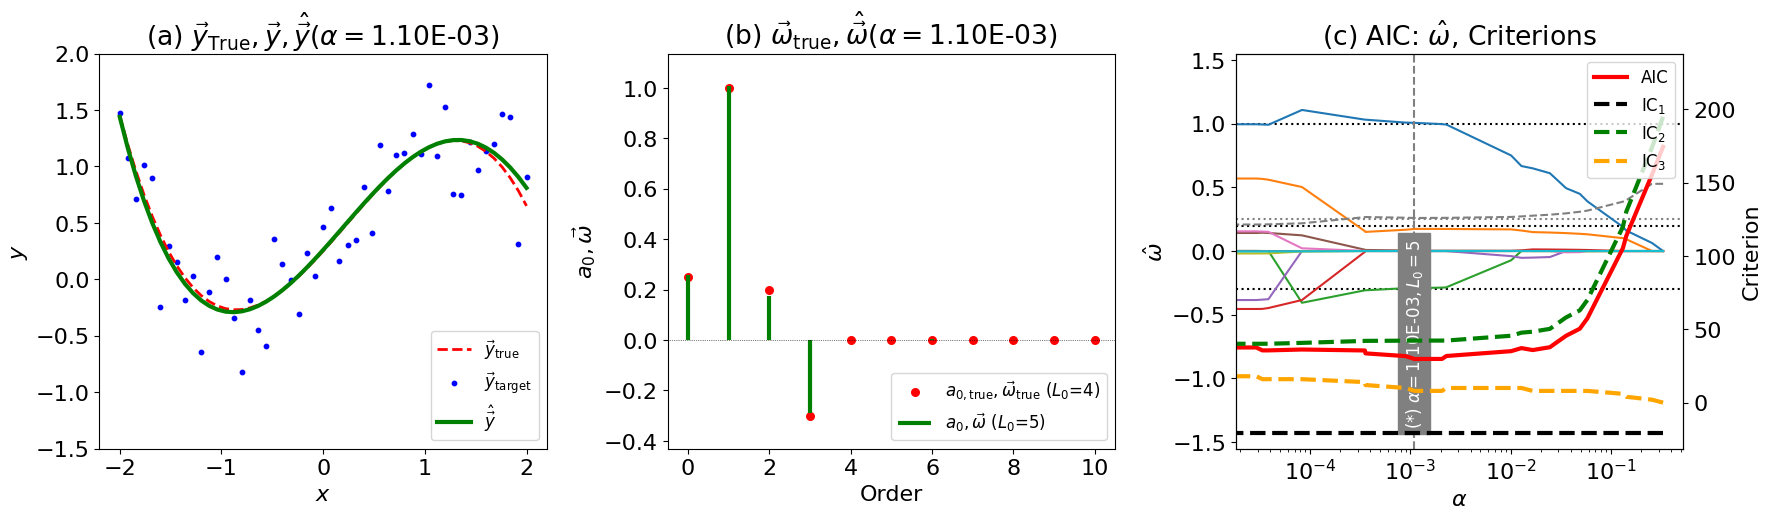

In [22]:
############################################
fig = Grf_ICsurveySummary( dictAICsurvey )
#
IC_upper_ = dictAICsurvey[ 'IC_upper' ]
#
pdfFName = FilePath + FileBaseName + '-' + IC_upper_ + '-summary-02.pdf'
fig.savefig( pdfFName )

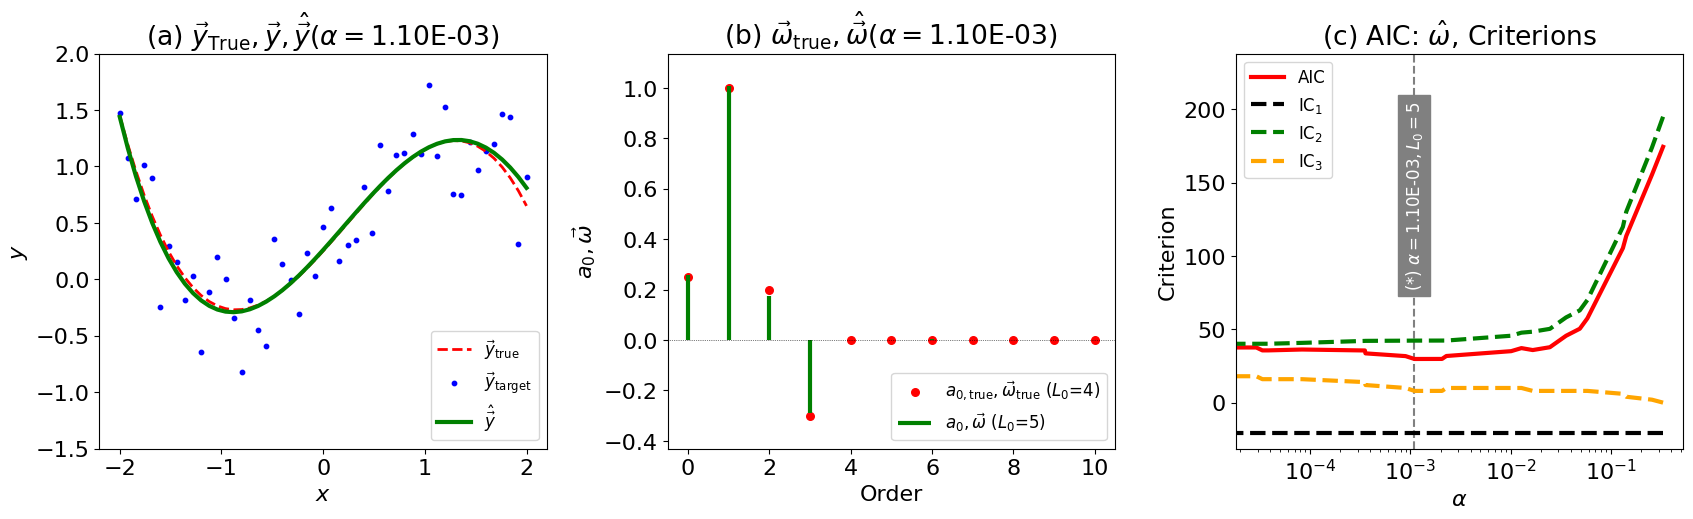

In [23]:
############################################
fig = Grf_ICsurveySummary_v2( dictAICsurvey )
#
IC_upper_ = dictAICsurvey[ 'IC_upper' ]
#
pdfFName = FilePath + FileBaseName + '-' + IC_upper_ + '-summary-01.pdf'
fig.savefig( pdfFName )

全ての $\alpha$ の結果出力

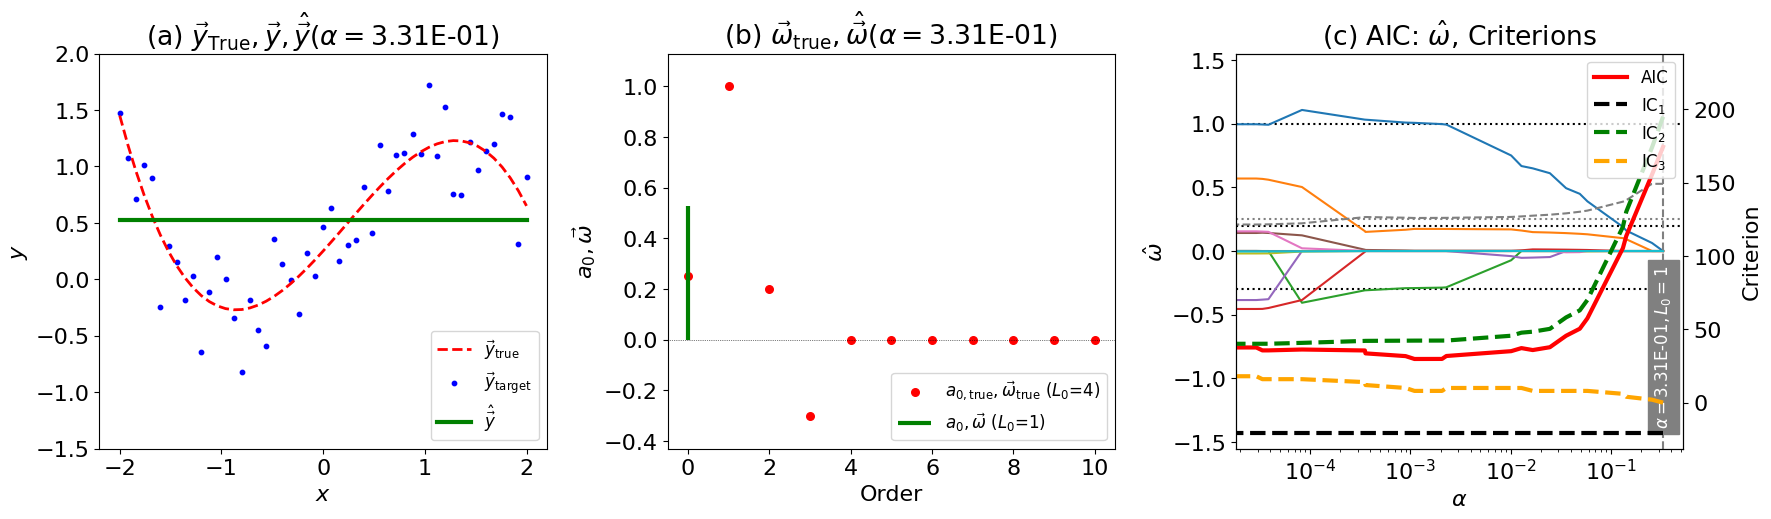

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-000-summary-01.pdf


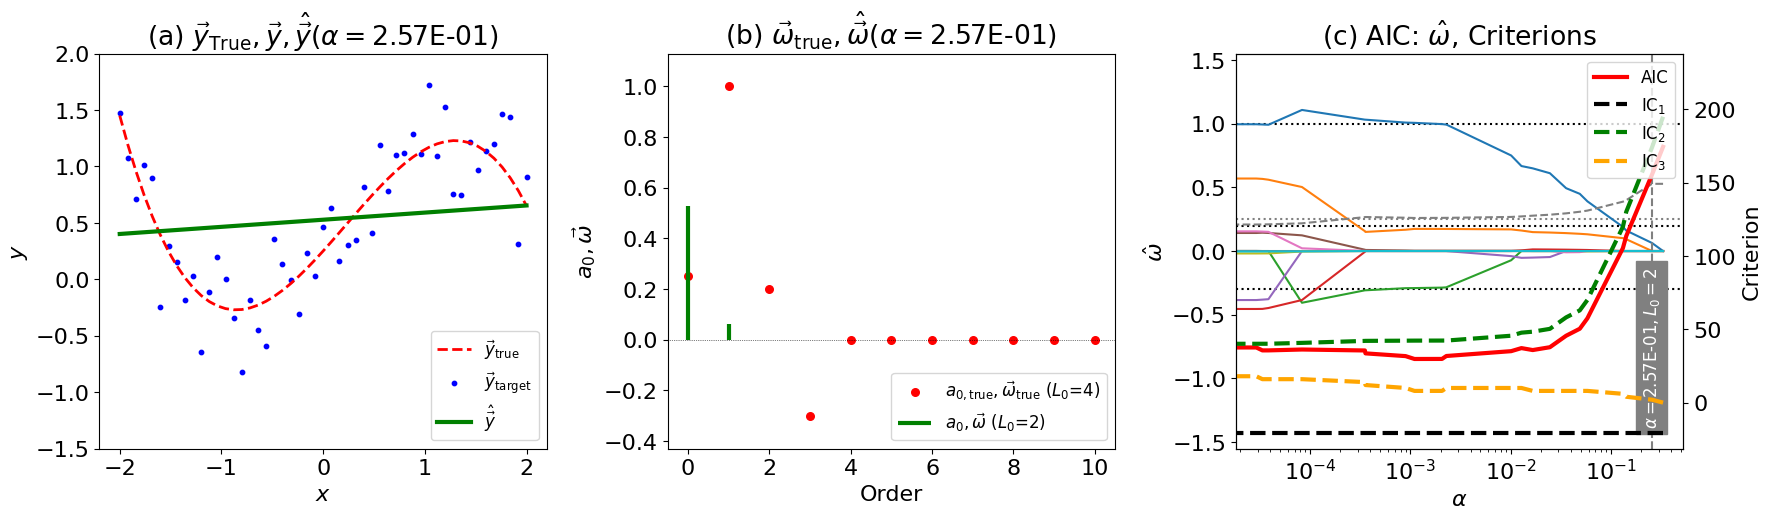

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-001-summary-01.pdf


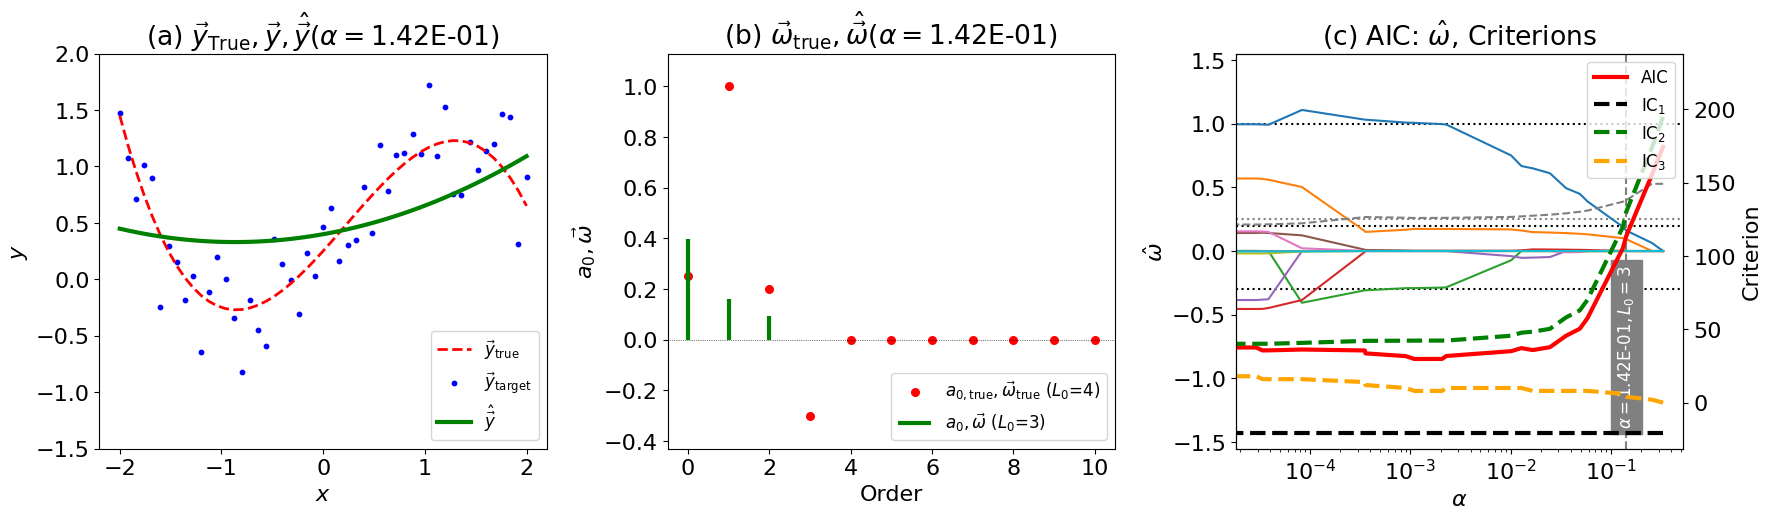

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-002-summary-01.pdf


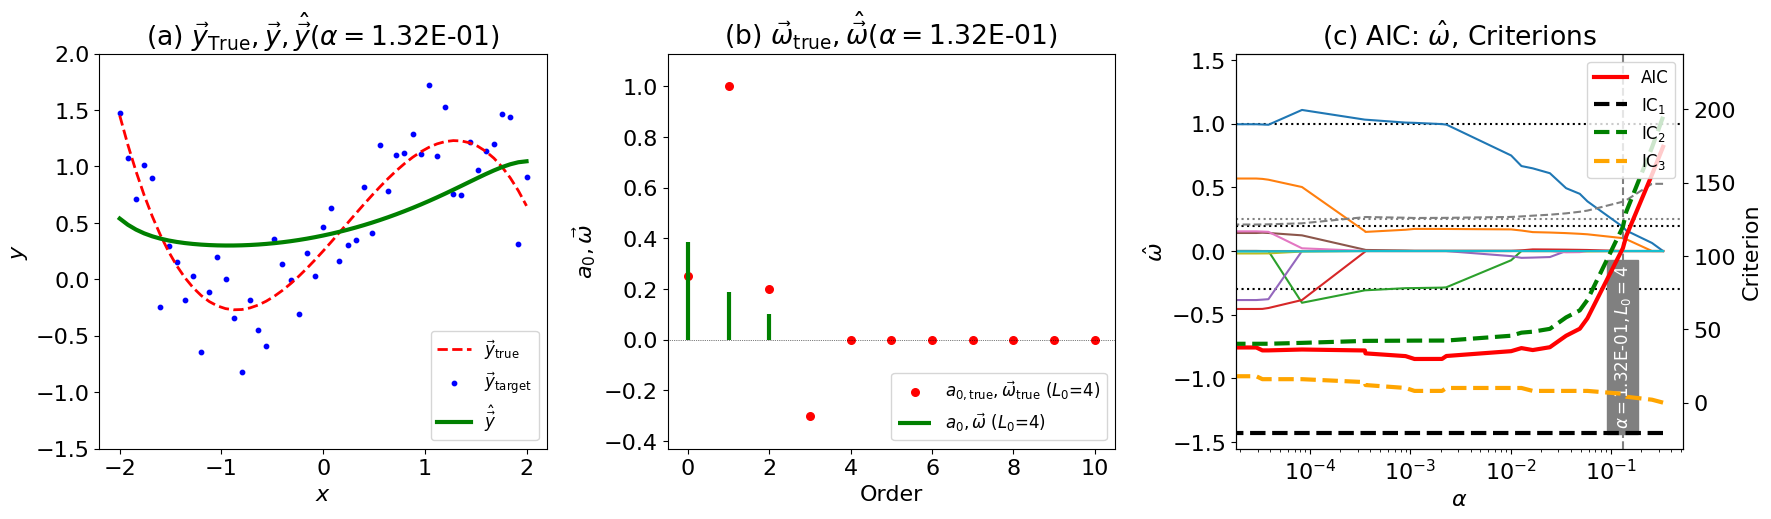

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-003-summary-01.pdf


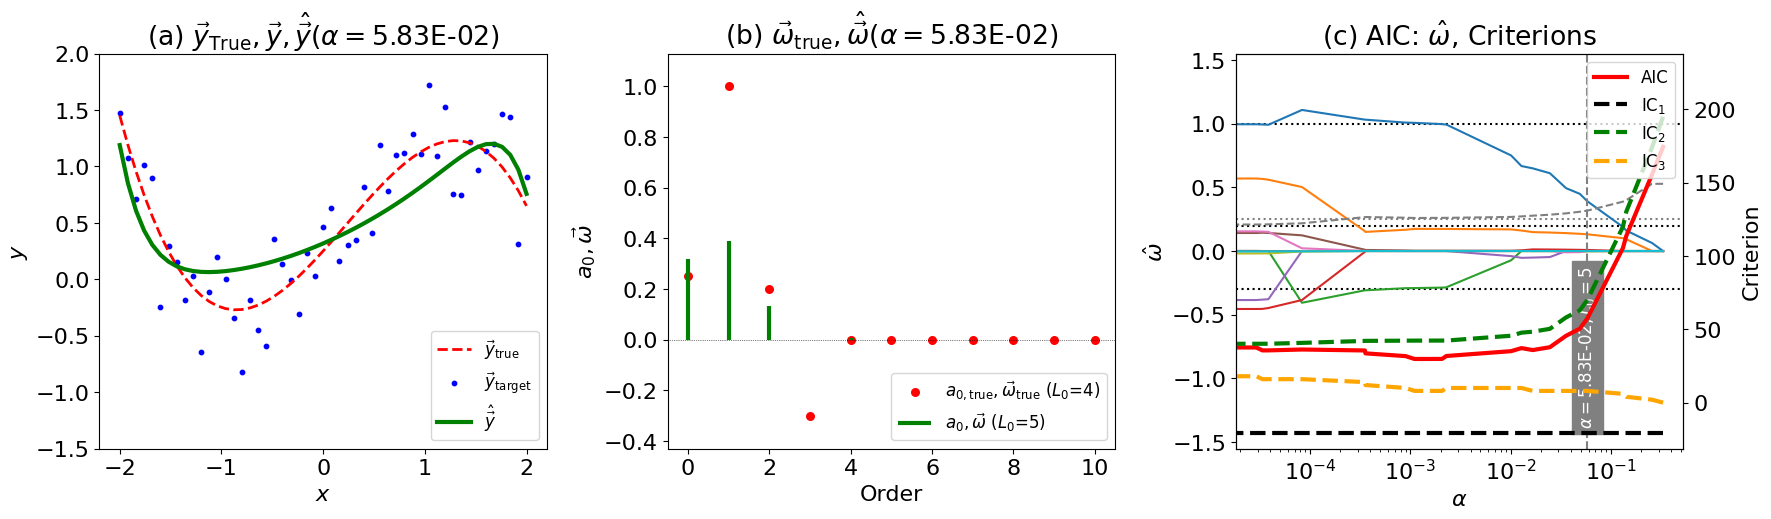

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-004-summary-01.pdf


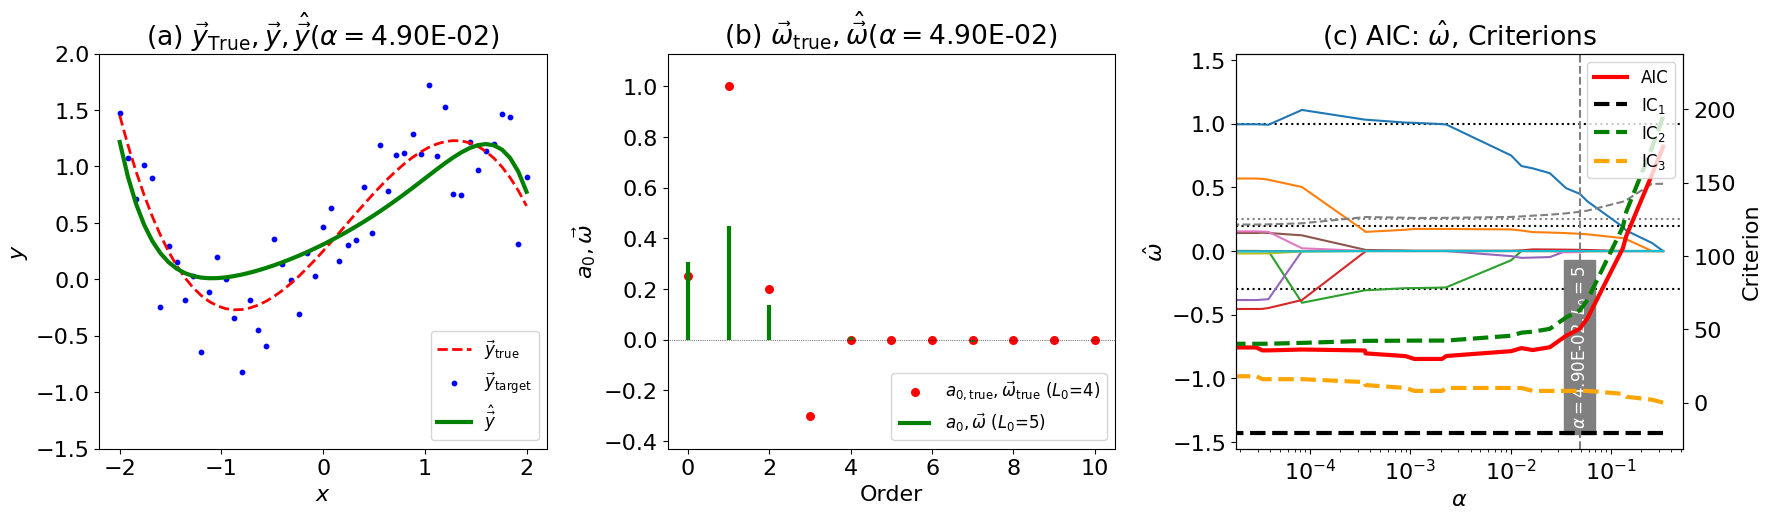

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-005-summary-01.pdf


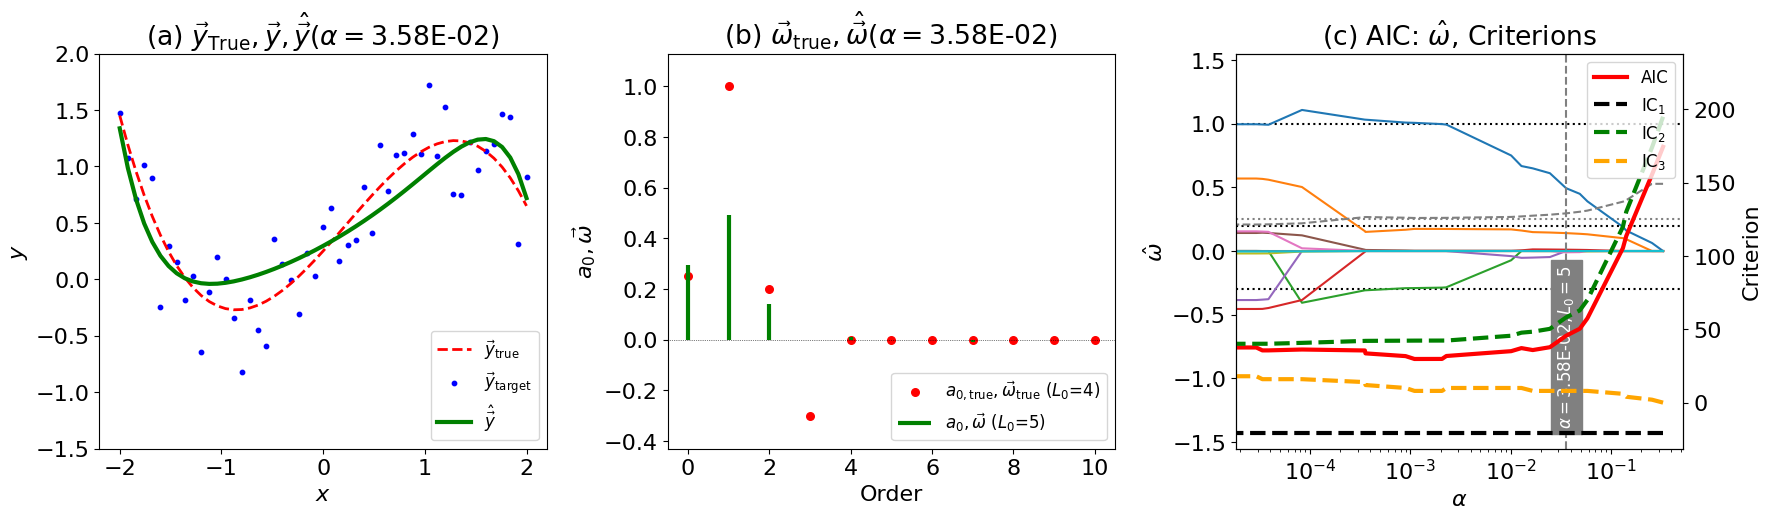

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-006-summary-01.pdf


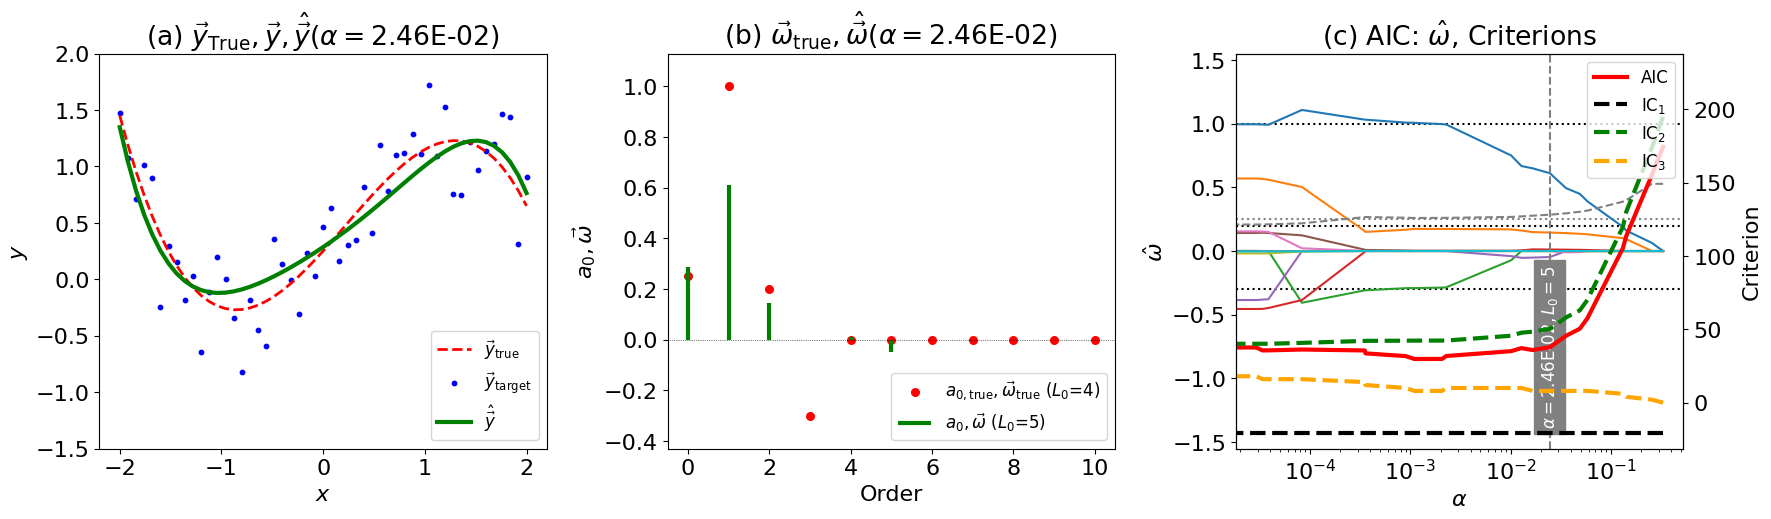

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-007-summary-01.pdf


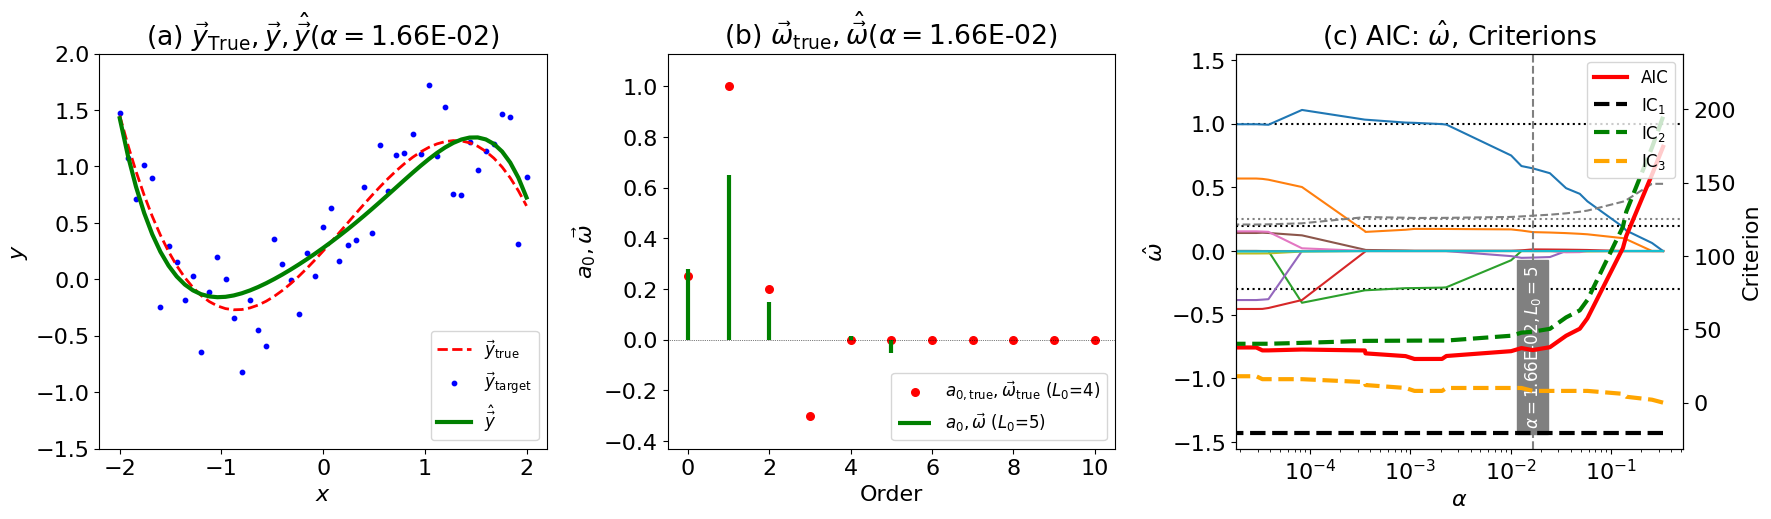

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-008-summary-01.pdf


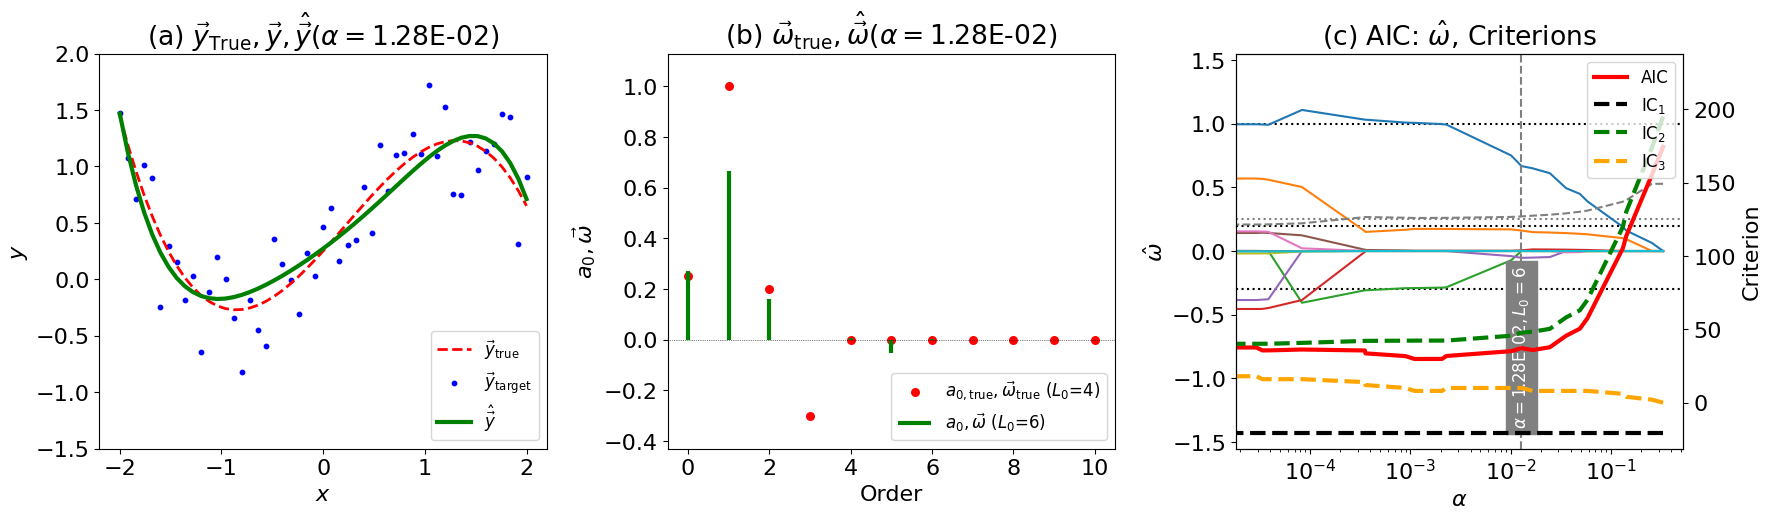

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-009-summary-01.pdf


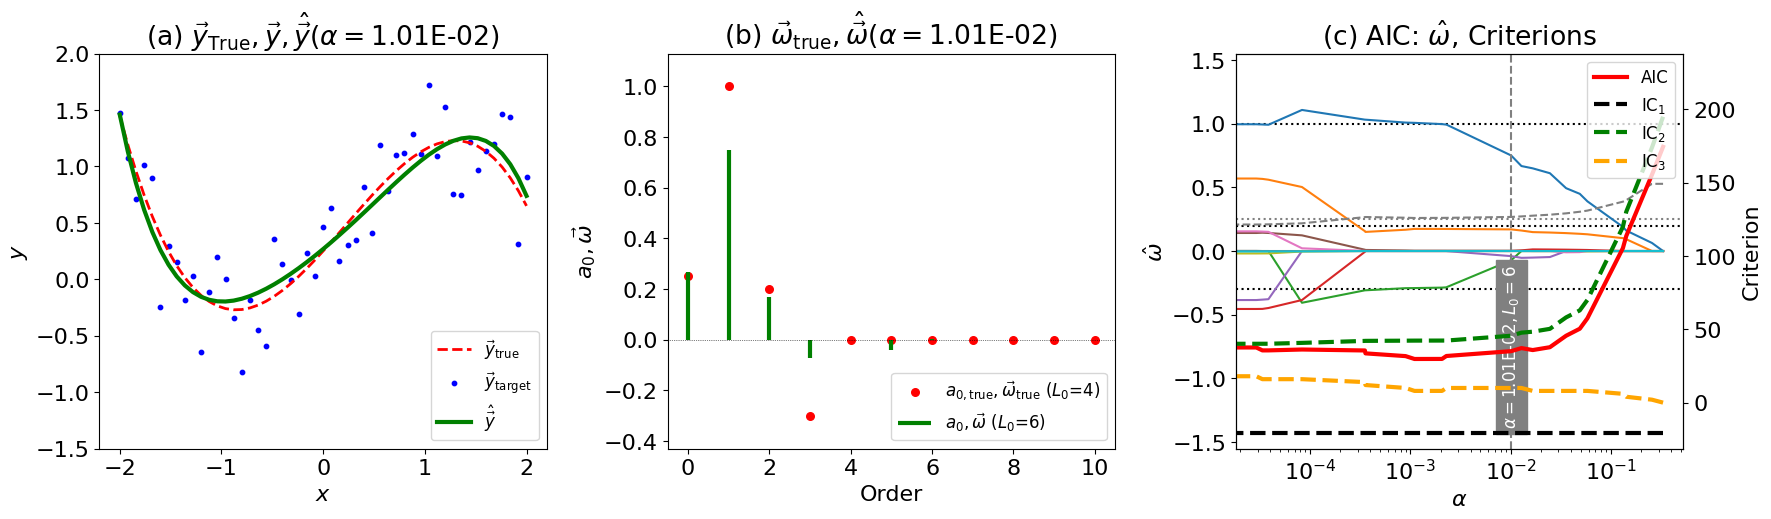

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-010-summary-01.pdf


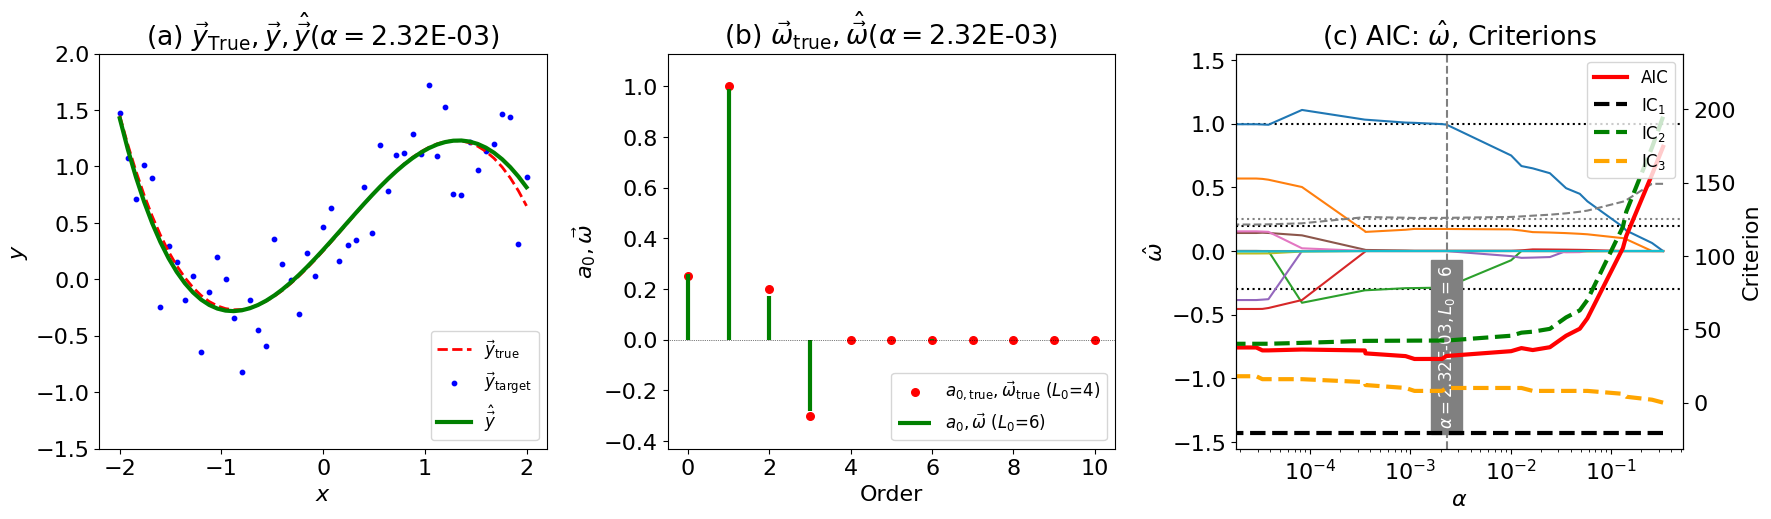

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-011-summary-01.pdf


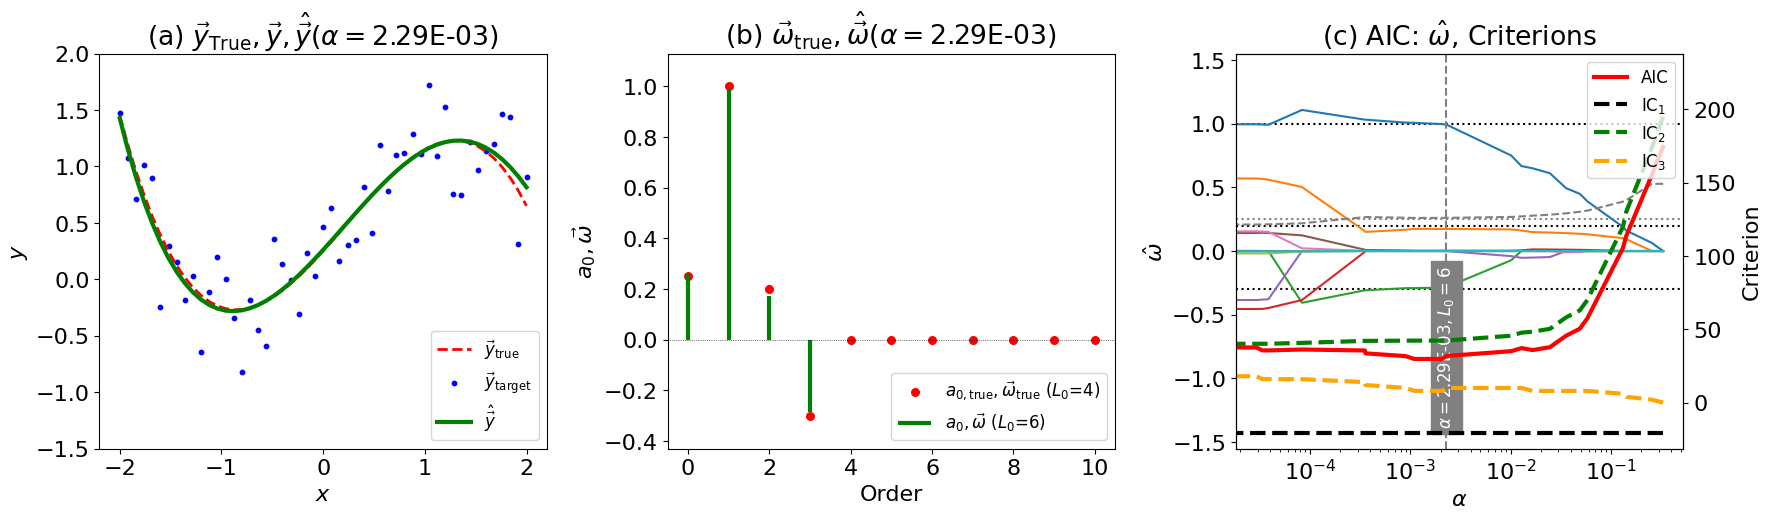

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-012-summary-01.pdf


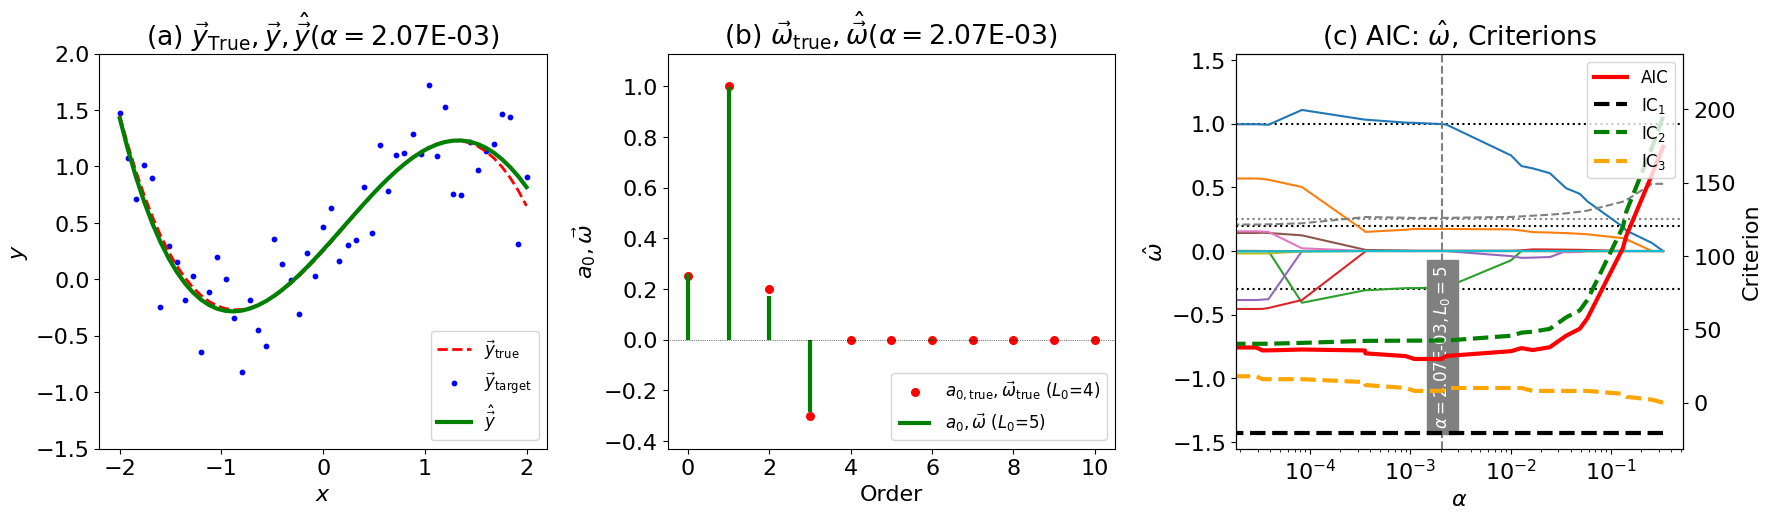

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-013-summary-01.pdf


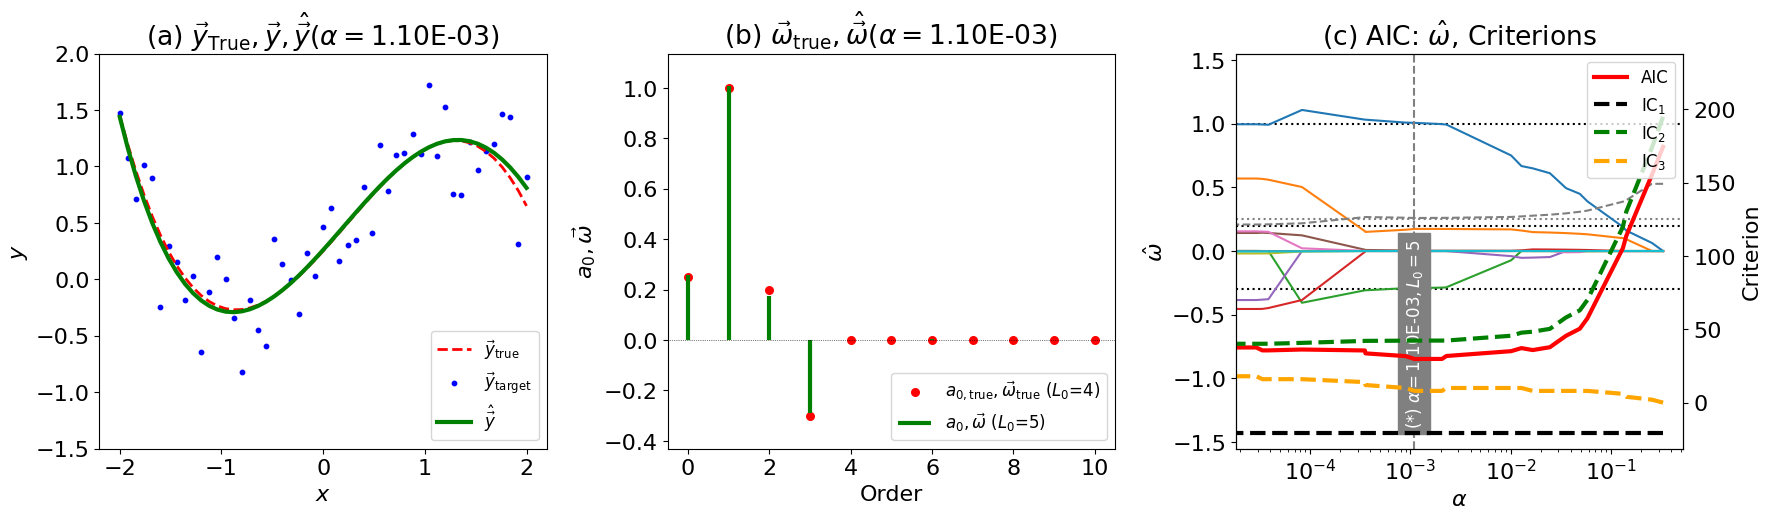

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-014-summary-01.pdf


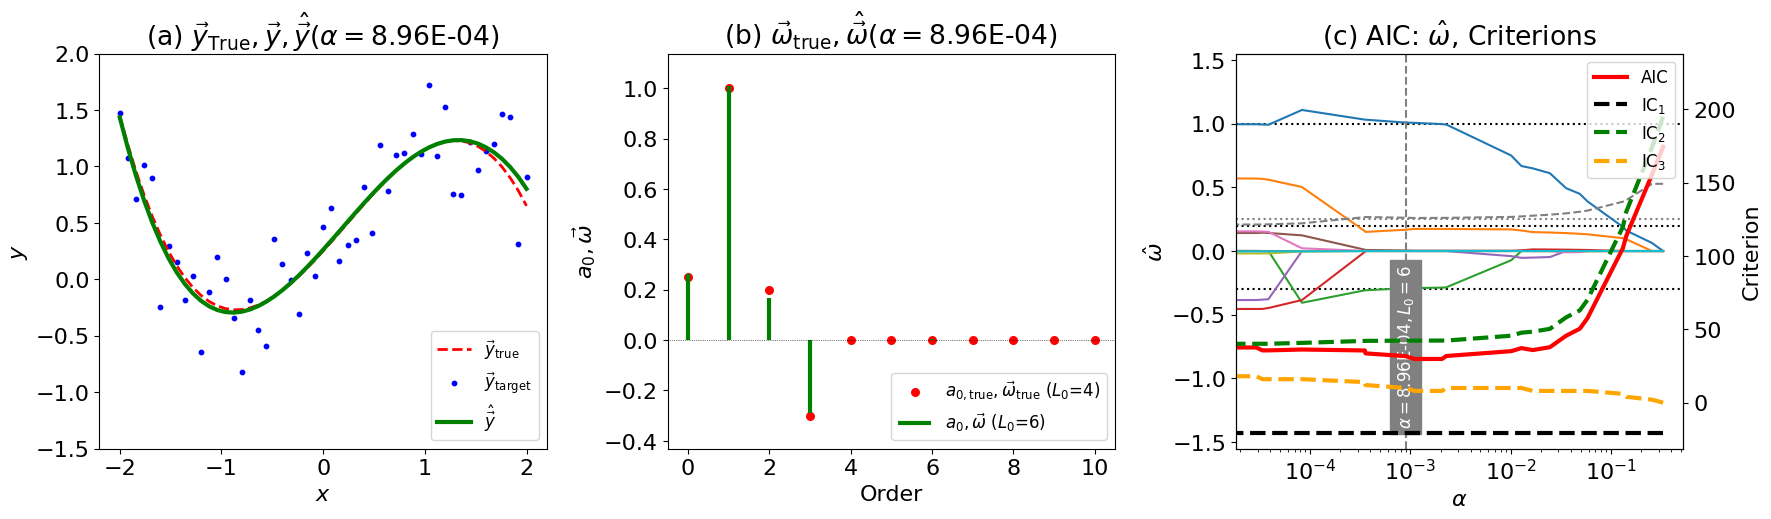

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-015-summary-01.pdf


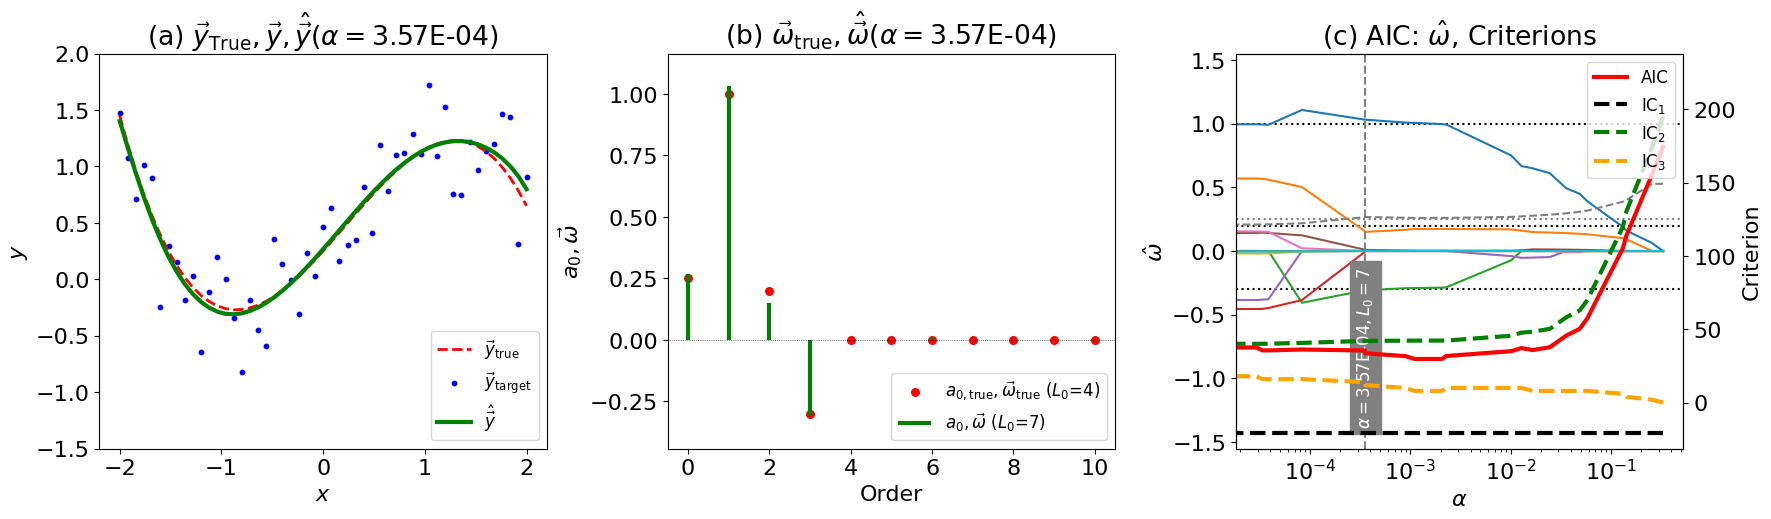

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-016-summary-01.pdf


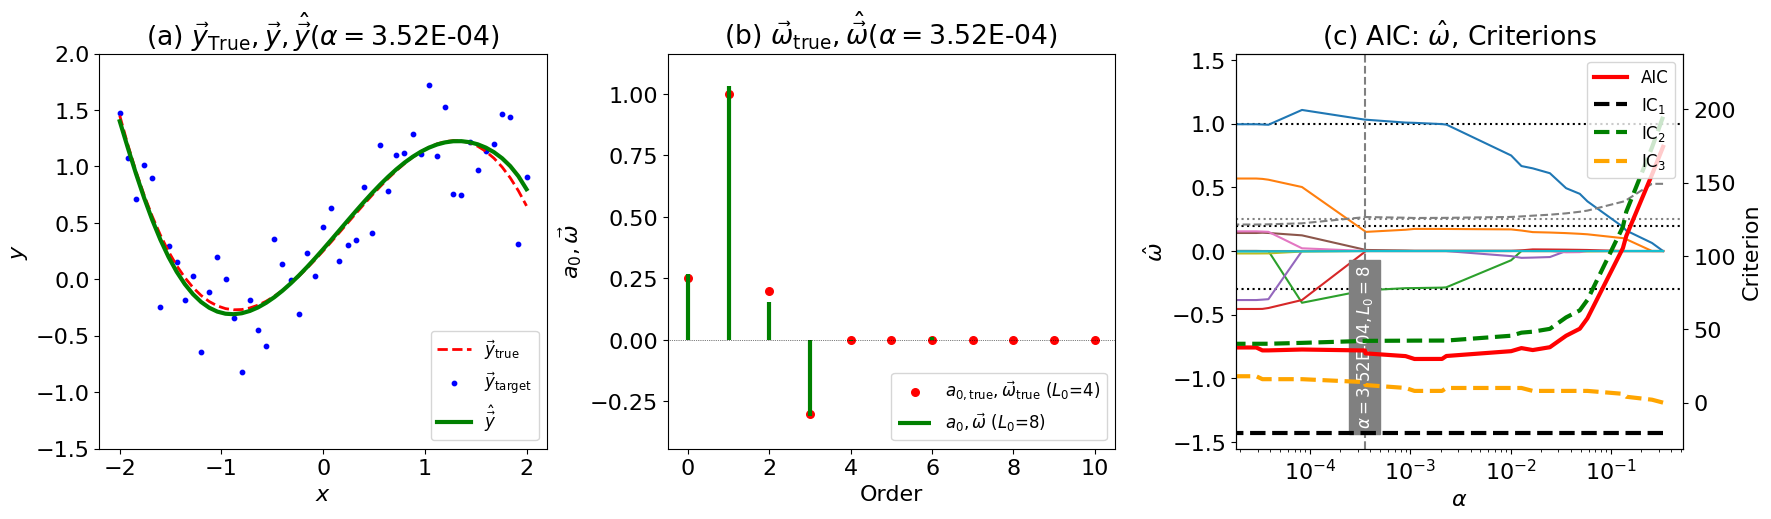

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-017-summary-01.pdf


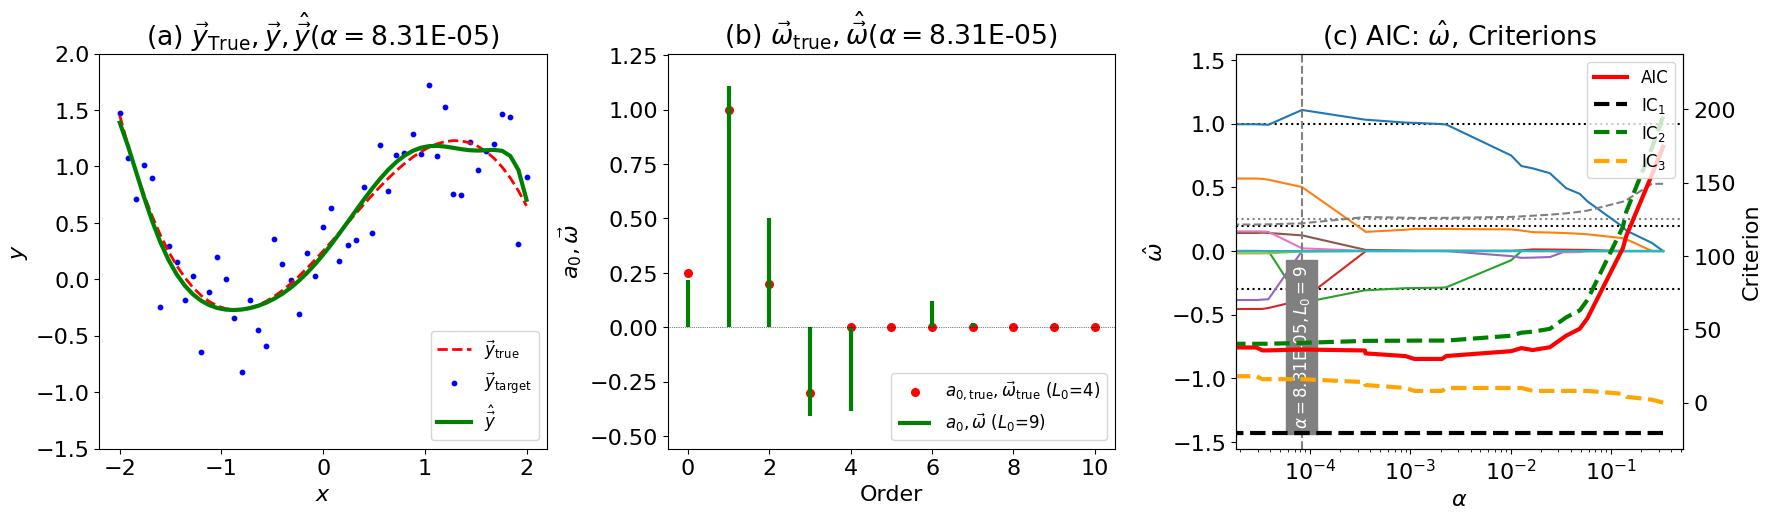

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-018-summary-01.pdf


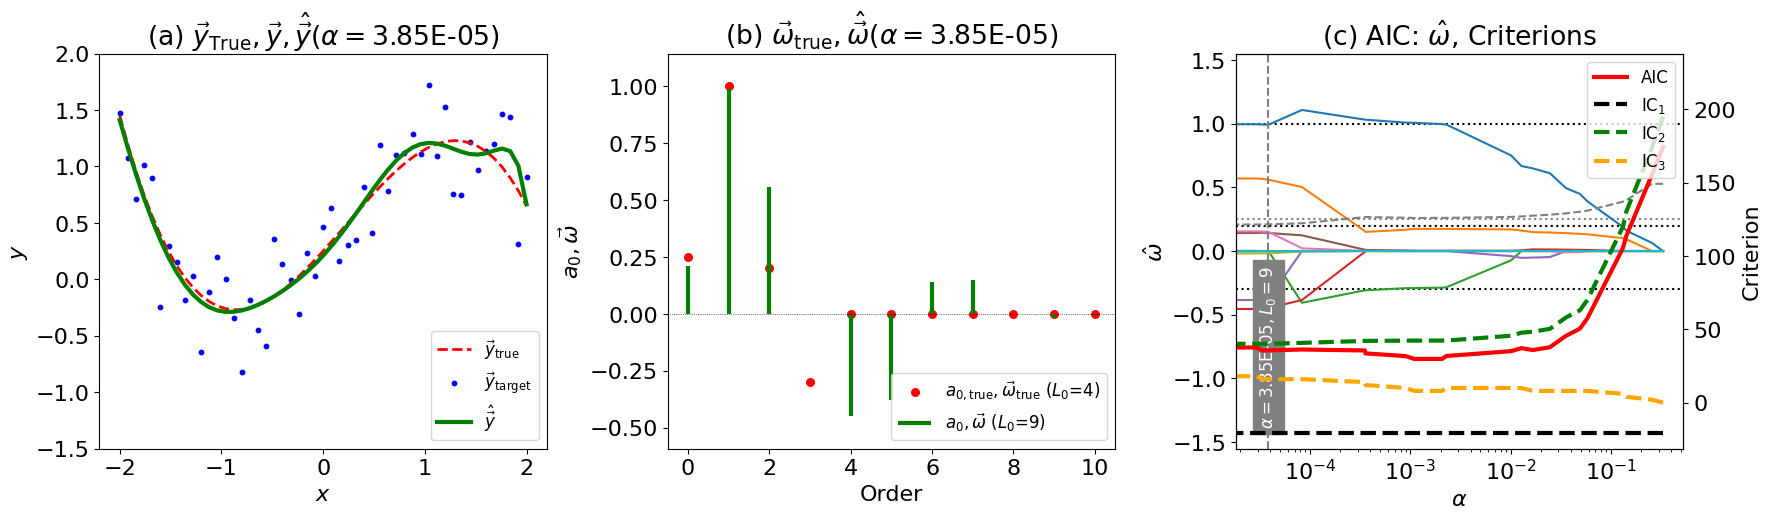

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-019-summary-01.pdf


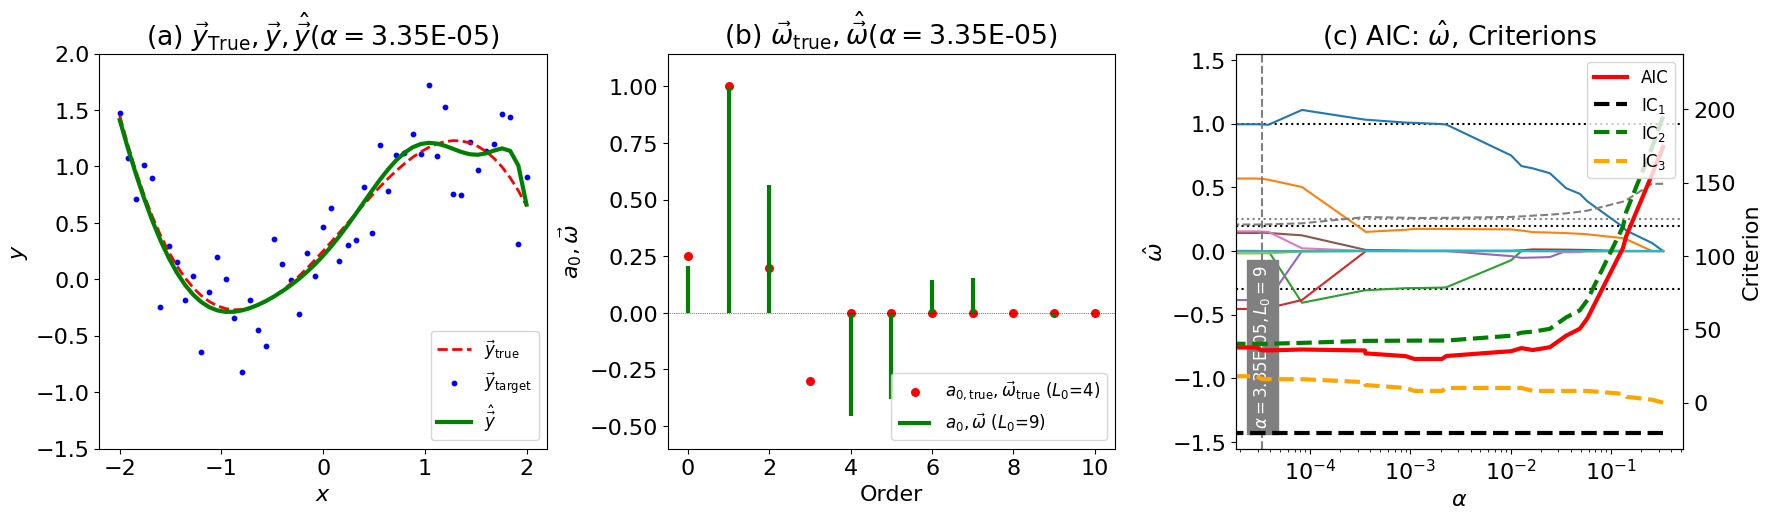

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-020-summary-01.pdf


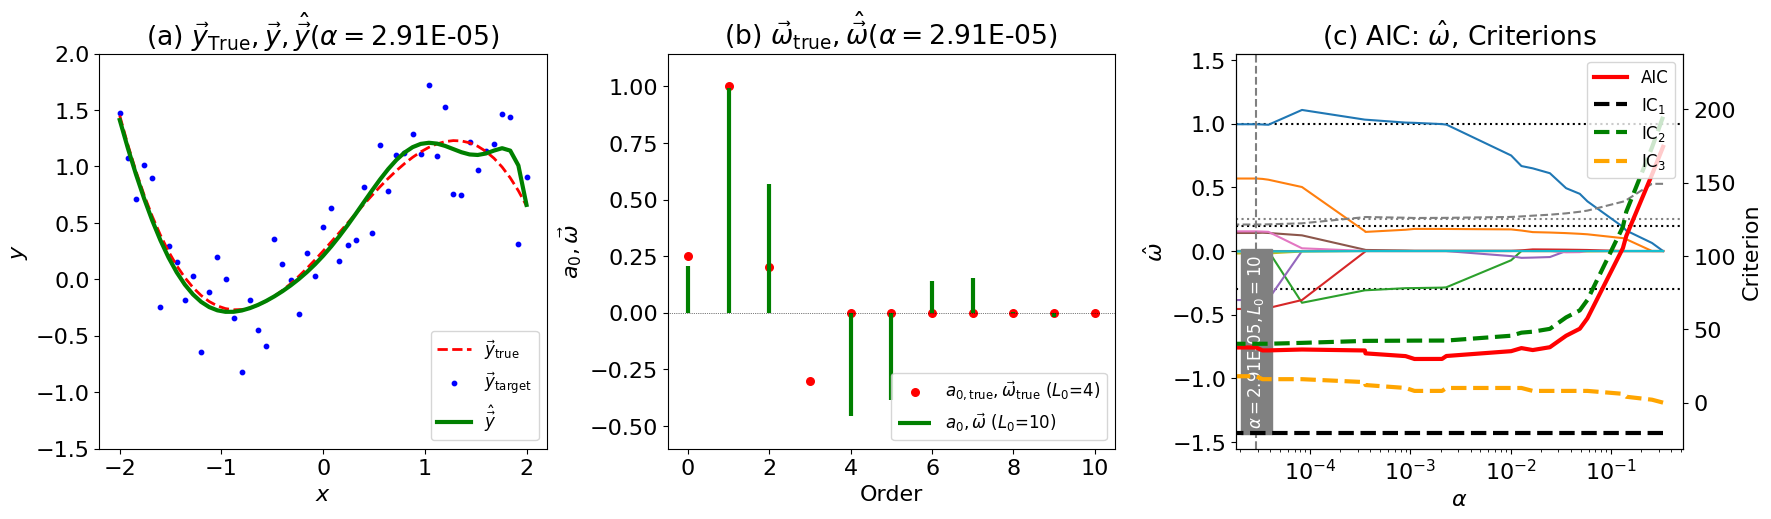

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-021-summary-01.pdf


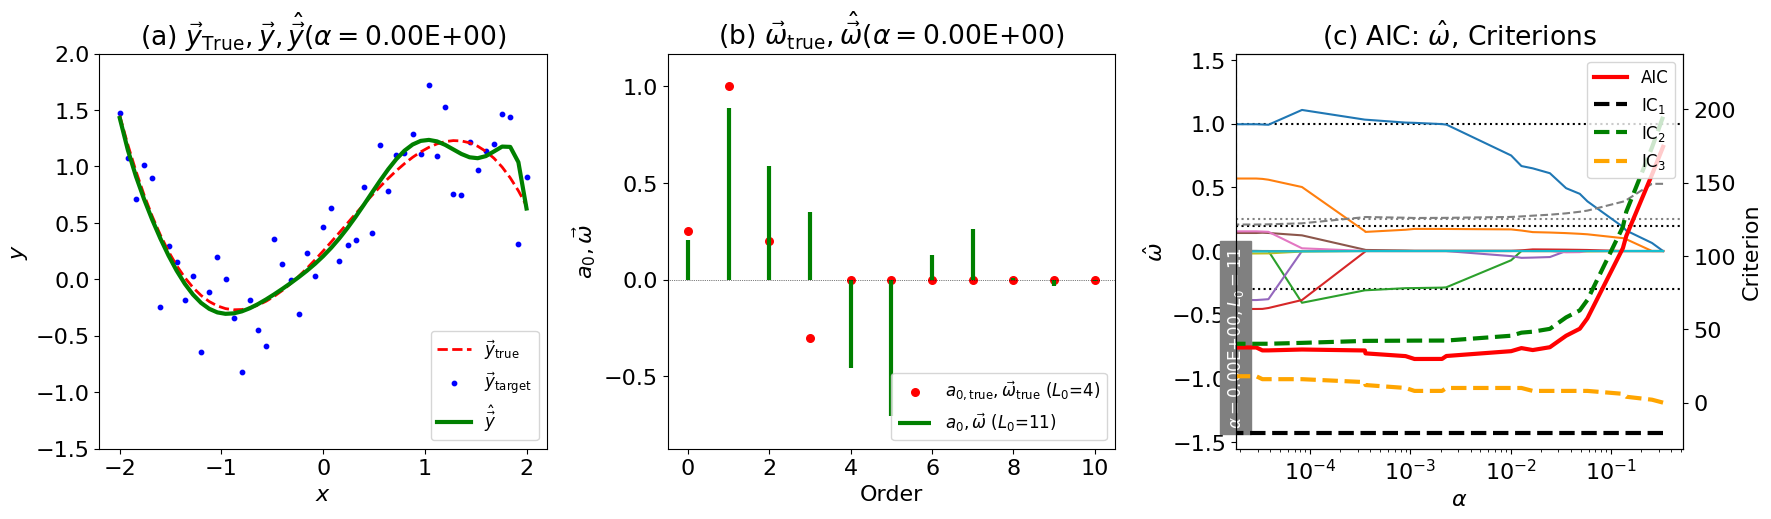

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-AIC-022-summary-01.pdf


In [24]:
############################################
IC_upper_ = dictAICsurvey[ 'IC_upper' ]
alphas_   = dictAICsurvey[ 'alphas'   ]
#
for idx_ in range( len( alphas_ ) ):
  #
  fig = Grf_ICsurveySummary( dictAICsurvey, idx_=idx_ )
  #
  #
  pdfFName = FilePath + FileBaseName + '-' + IC_upper_ + '-%03d-summary-01.pdf' % idx_
  print( pdfFName )
  fig.savefig( pdfFName )

---
BICの実行

In [25]:
############################################
IC = 'bic'
############################################
IC_upper = str.upper( IC )
IC_lower = str.lower( IC )
############################################
# AICの実行
dictBIC = dictICriterion( IC, y_target, X_ss )
#
print( dictBIC.keys() )

-- BIC ------------------
IC_noise_var =  0.10641760360335017
BIC : alpha=1.100E-03 : L0=  5 (=1+4): RMSD_y=2.971E-01
True: +0.2500 : +1.0000 : +0.2000 : -0.3000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 : +0.0000 :
BIC : +0.2593 : +1.0058 : +0.1736 : -0.2908 : +0.0000 : +0.0000 : +0.0027 : +0.0000 : +0.0000 : +0.0000 : +0.0000 :
dict_keys(['IC_upper', 'IC_alpha', 'IC_coef', 'IC_intercept', 'IC_noise_var', 'alphas', 'criterions', 'IC_yreg', 'IC_yreg_RMSD', 'IC_L0', 'IC_coef_org', 'IC_intercept_org', 'IC_wspec'])


情報量規準を確認する関数を実行する。

In [26]:
############################################
dictBICsurvey = dictICsurvey( dictBIC, y_target, X_ss, sdash_vec, mu_vec )
#
print( dictBICsurvey.keys() )

noise_variance = 1.0642E-01
IC_noise_var   = 1.0642E-01
  idx: alpha      : criterion  : L0           : RMSDtarget : RMSDtrue   : wRMSDtrue  : ICcheck    : IC_0       : IC_1       : IC_2      
    0: 3.3132E-01 : 1.7450E+02 :   1 (=1+  0) : 6.3792E-01 : 5.4470E-01 : 3.2637E-01 : 1.7450E+02 : -2.0528E+01 : 1.9503E+02 : 0.0000E+00 
    1: 2.5696E-01 : 1.5746E+02 :   2 (=1+  1) : 6.0266E-01 : 5.0810E-01 : 3.0986E-01 : 1.5746E+02 : -2.0528E+01 : 1.7406E+02 : 3.9318E+00 
    2: 1.4227E-01 : 1.1751E+02 :   3 (=1+  2) : 5.2118E-01 : 4.2037E-01 : 2.7067E-01 : 1.1751E+02 : -2.0528E+01 : 1.3017E+02 : 7.8637E+00 
    3: 1.3175E-01 : 1.1117E+02 :   4 (=1+  3) : 5.0020E-01 : 3.9463E-01 : 2.6209E-01 : 1.1117E+02 : -2.0528E+01 : 1.1991E+02 : 1.1795E+01 
    4: 5.8308E-02 : 6.5234E+01 :   5 (=1+  4) : 3.8228E-01 : 2.3494E-01 : 2.0516E-01 : 6.5234E+01 : -2.0528E+01 : 7.0035E+01 : 1.5727E+01 
    5: 4.8966E-02 : 5.8134E+01 :   5 (=1+  4) : 3.6238E-01 : 2.0131E-01 : 1.8964E-01 : 5.8134E+01 : -2.0528E+01 

BICの結果まとめのグラフ

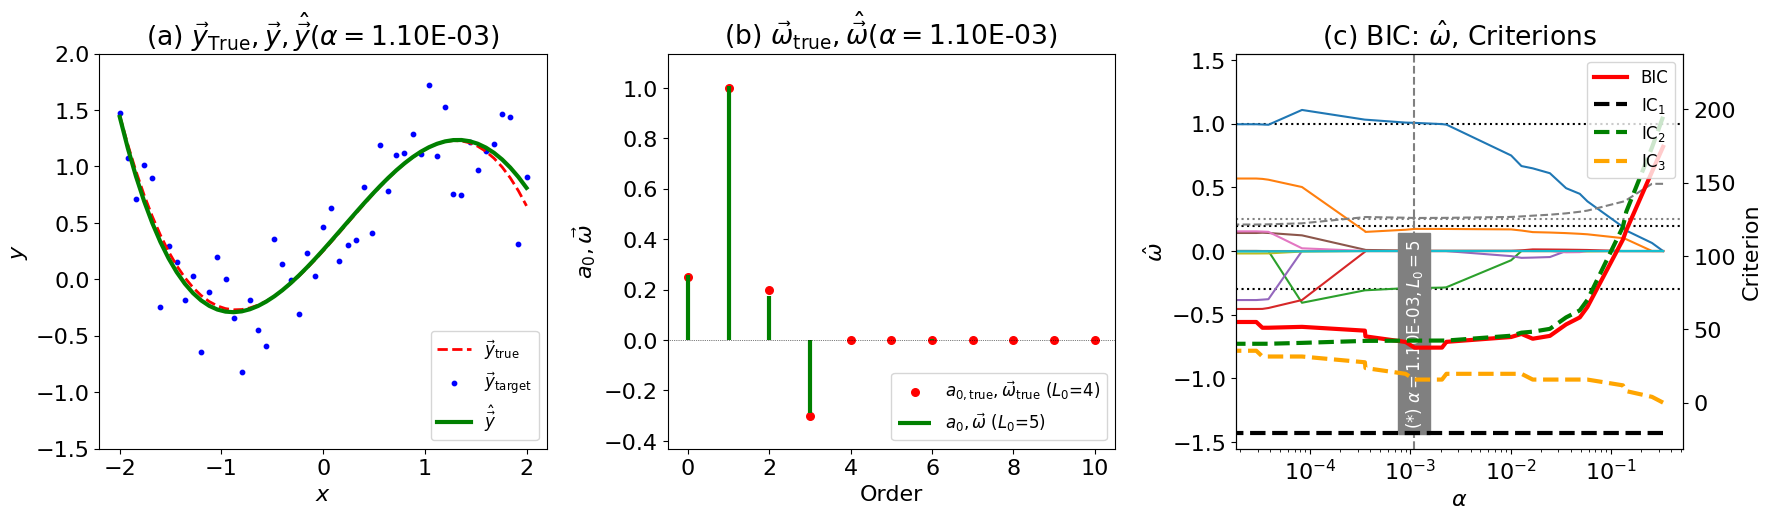

In [27]:
############################################
fig = Grf_ICsurveySummary( dictBICsurvey )
#
IC_upper_ = dictBICsurvey[ 'IC_upper' ]
#
pdfFName = FilePath + FileBaseName + '-' + IC_upper_ + '-summary-02.pdf'
fig.savefig( pdfFName )

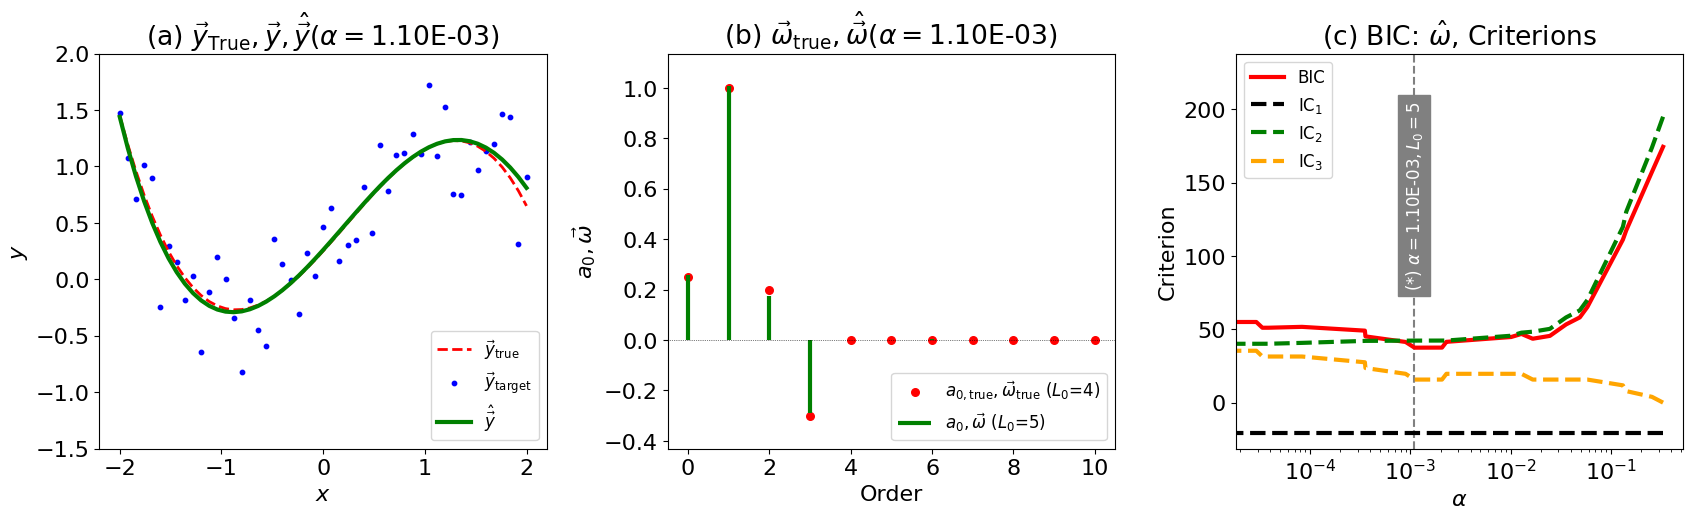

In [28]:
############################################
fig = Grf_ICsurveySummary_v2( dictBICsurvey )
#
IC_upper_ = dictBICsurvey[ 'IC_upper' ]
#
pdfFName = FilePath + FileBaseName + '-' + IC_upper_ + '-summary-01.pdf'
fig.savefig( pdfFName )

全ての $\alpha$ の結果出力

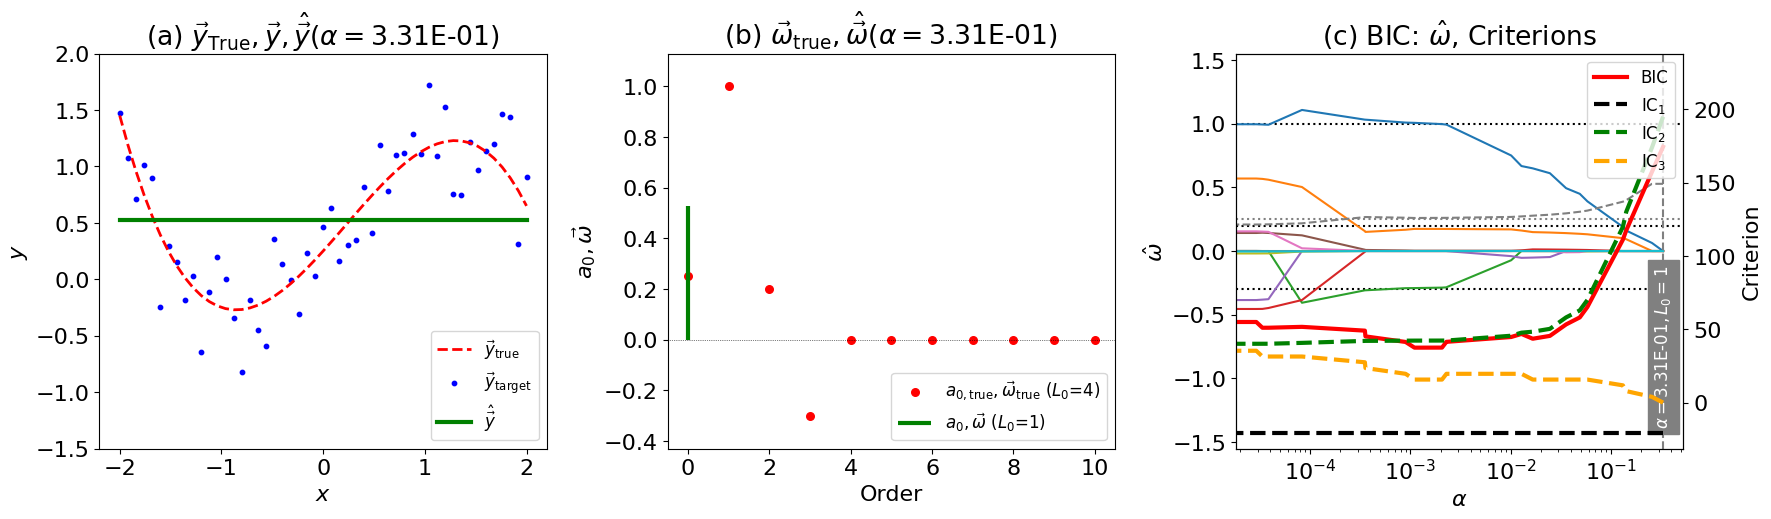

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-000-summary-01.pdf


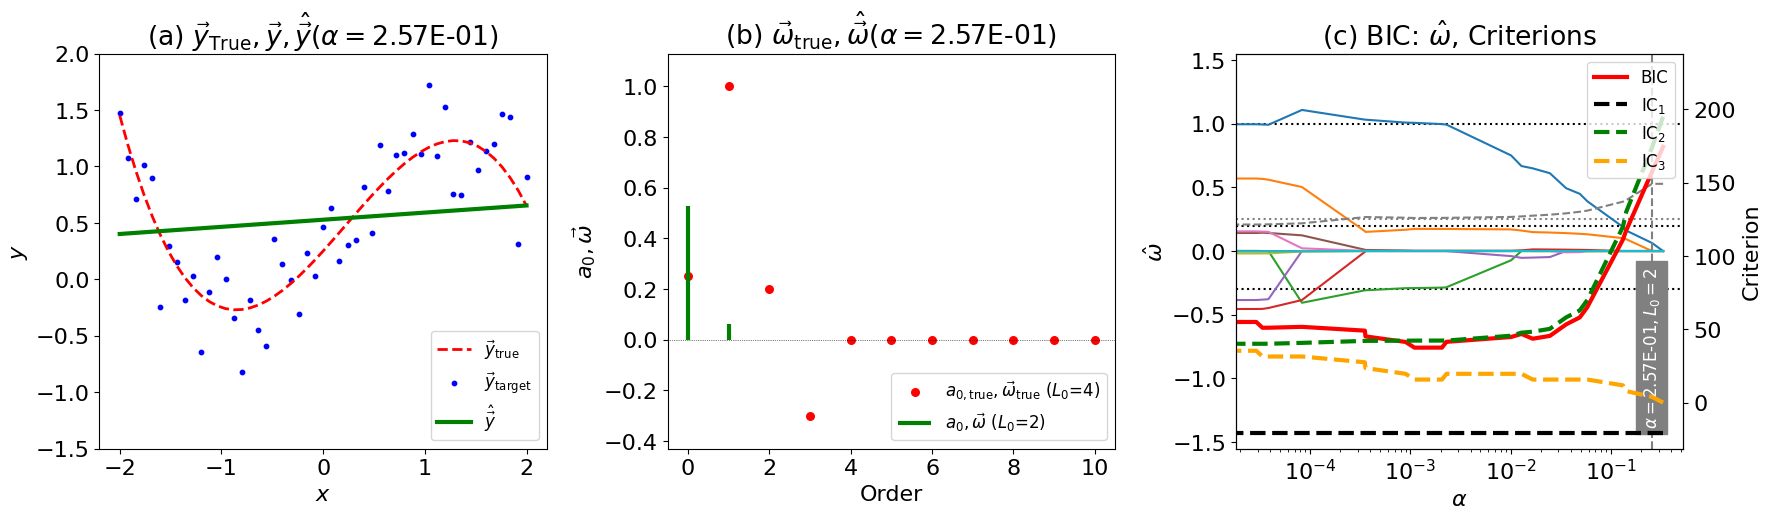

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-001-summary-01.pdf


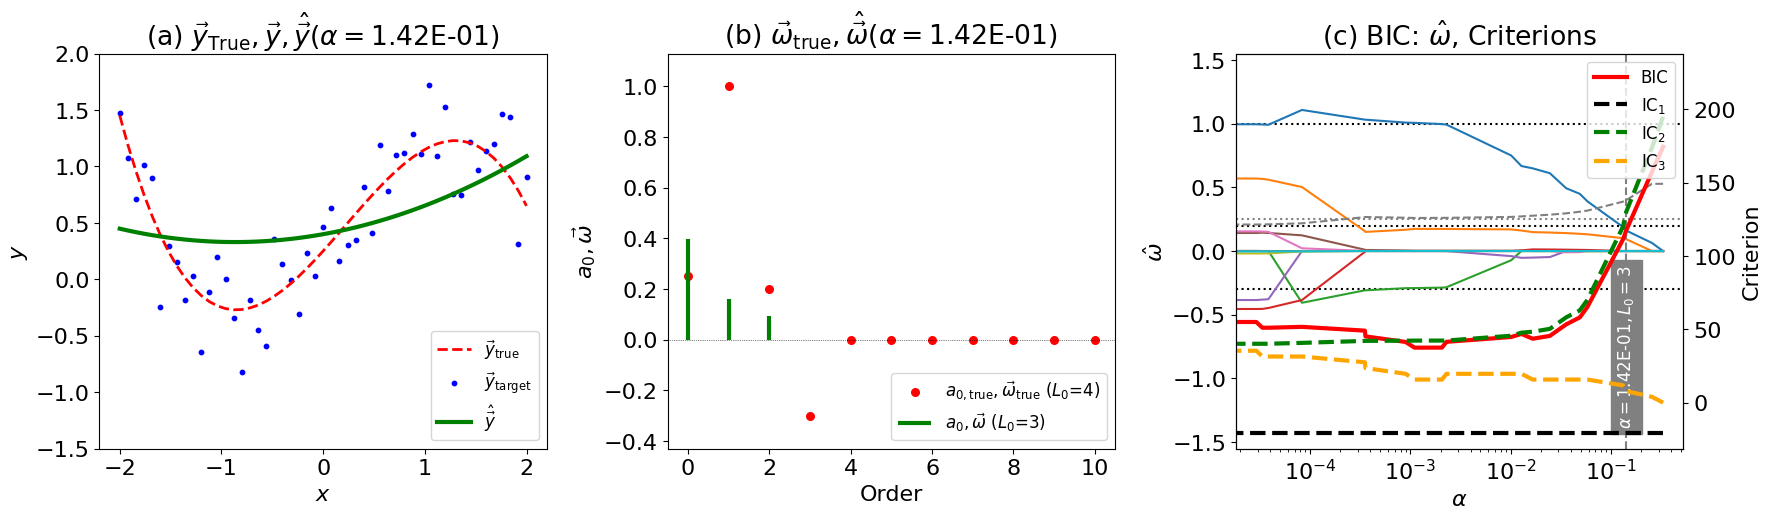

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-002-summary-01.pdf


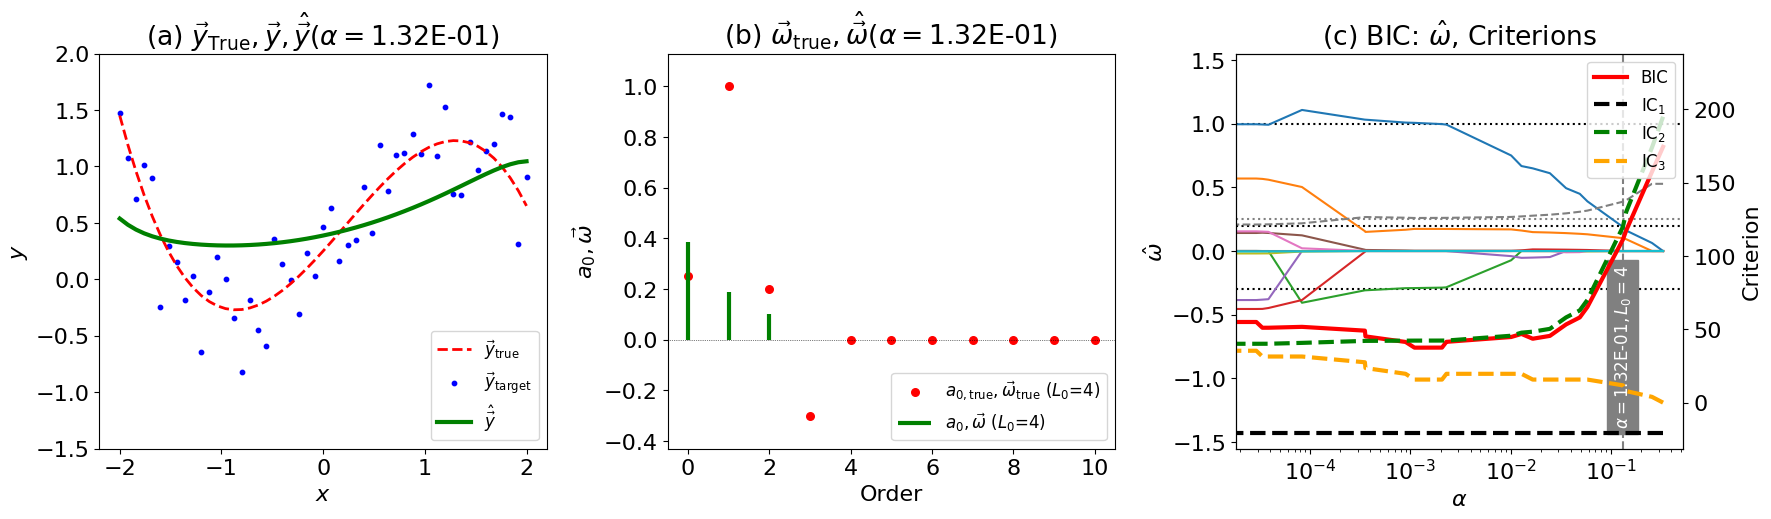

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-003-summary-01.pdf


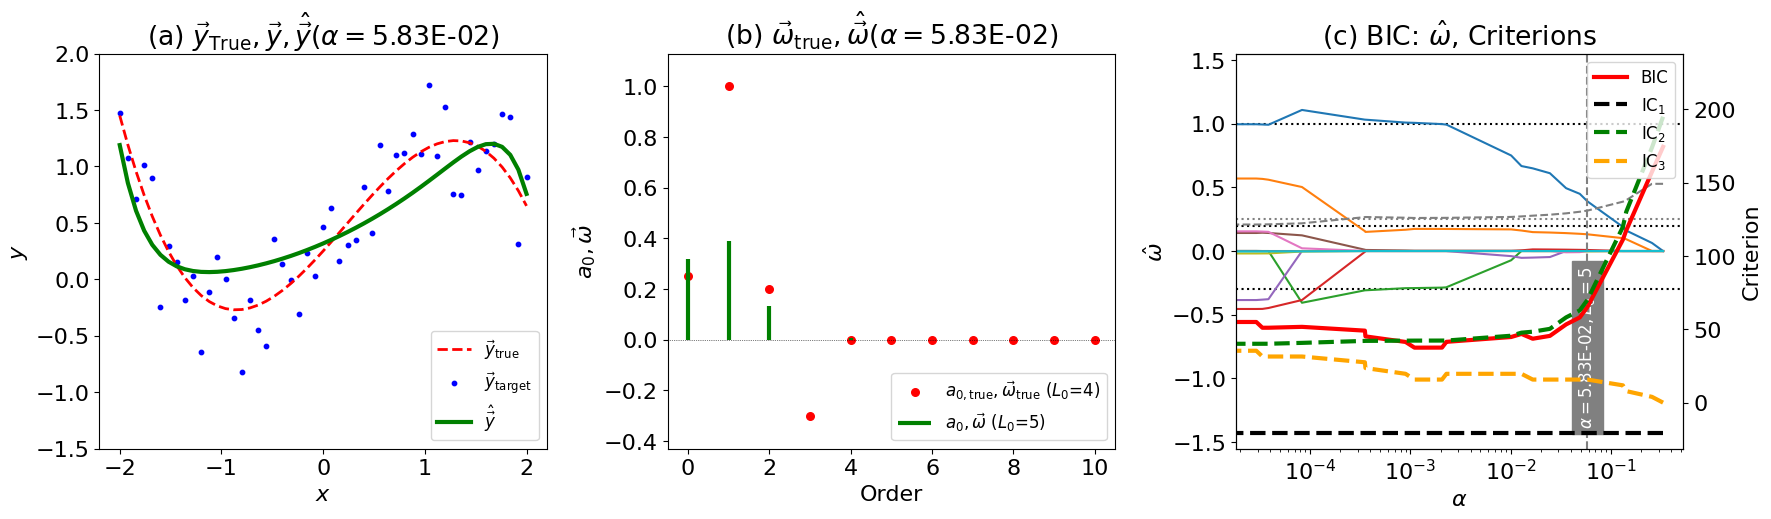

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-004-summary-01.pdf


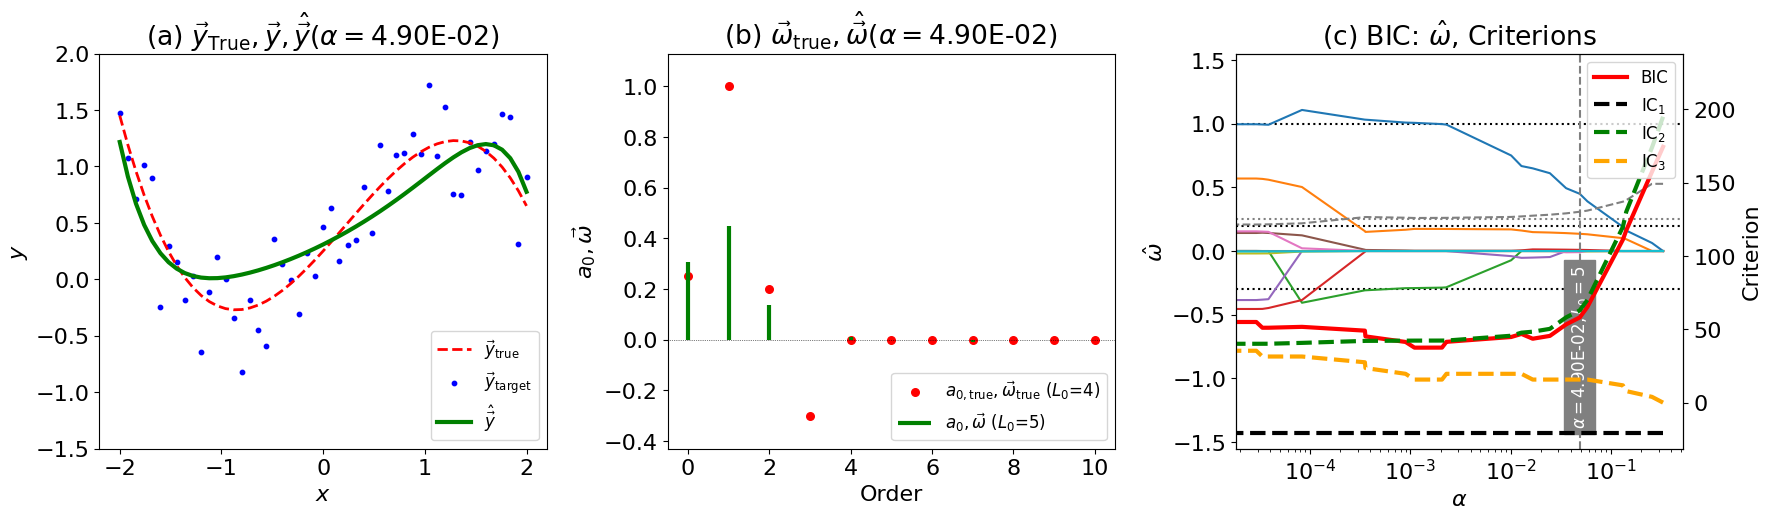

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-005-summary-01.pdf


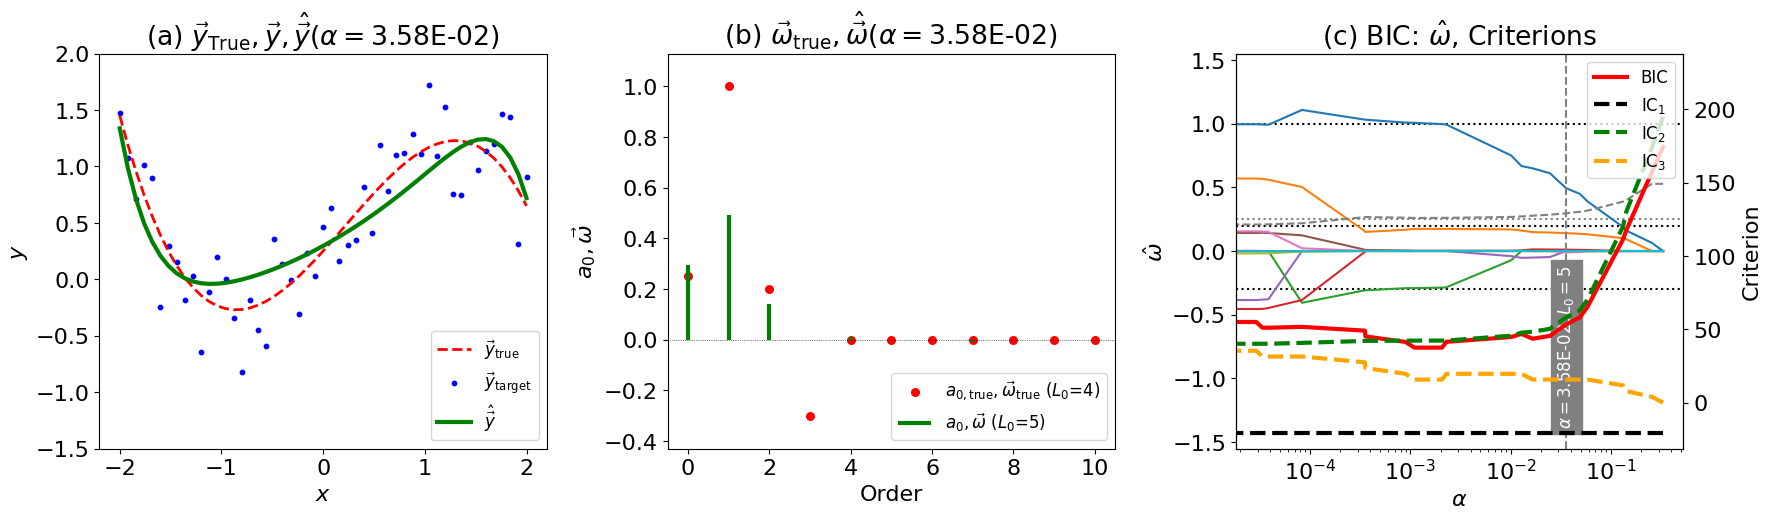

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-006-summary-01.pdf


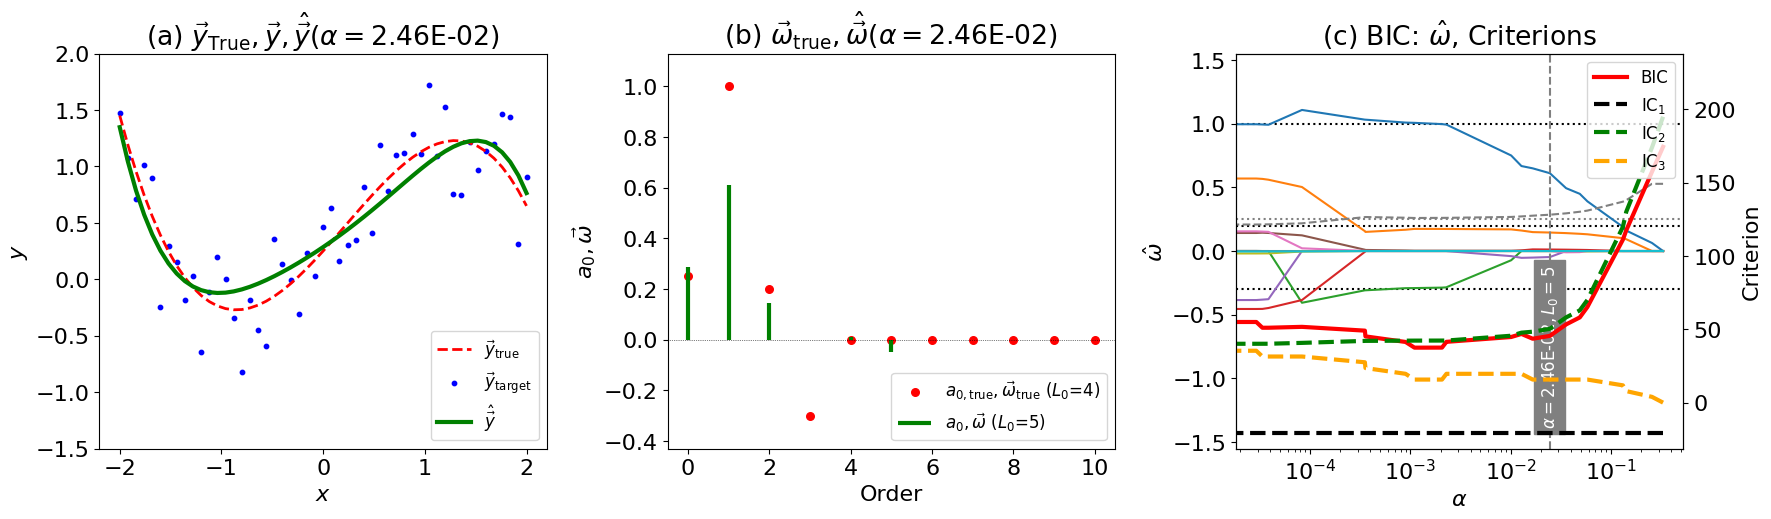

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-007-summary-01.pdf


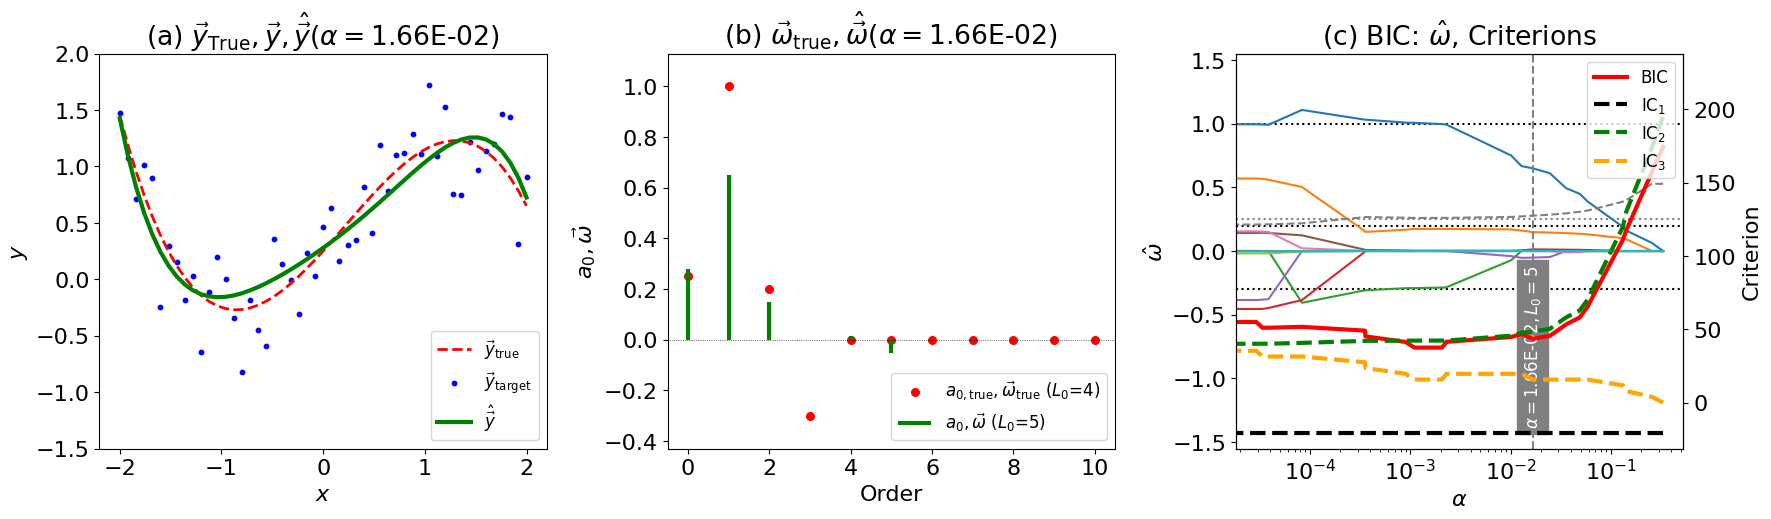

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-008-summary-01.pdf


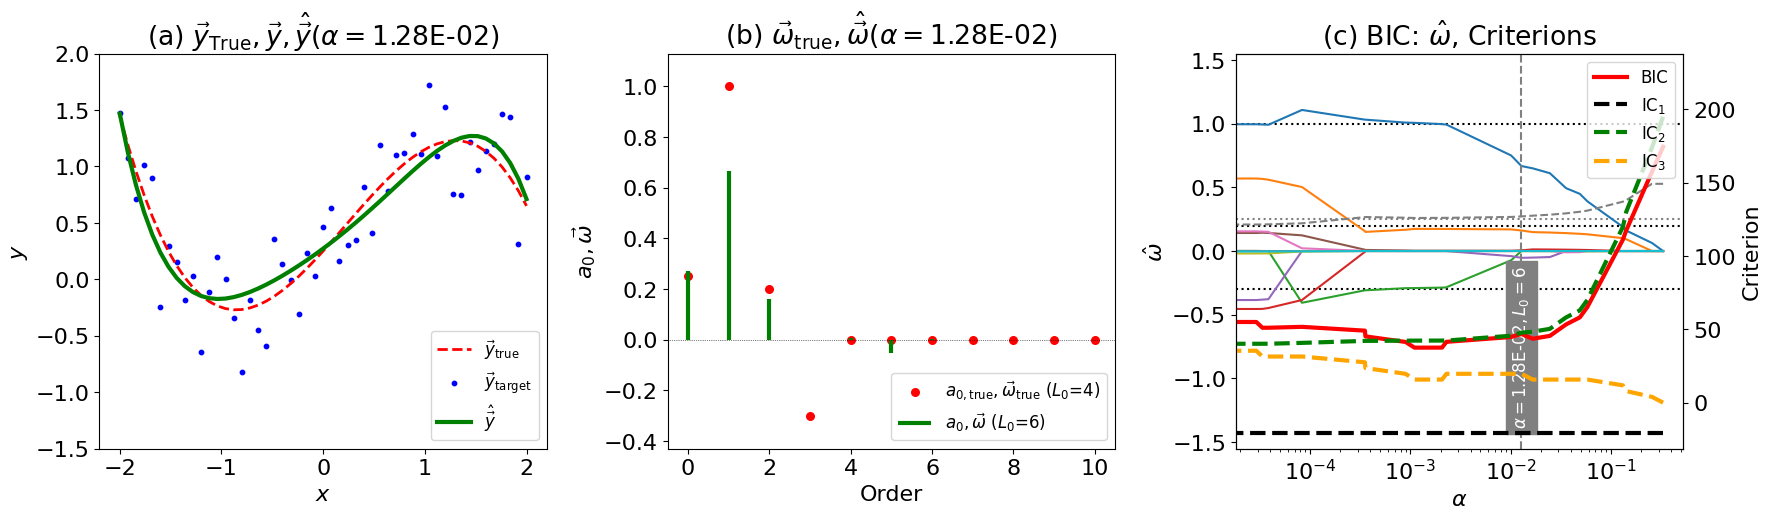

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-009-summary-01.pdf


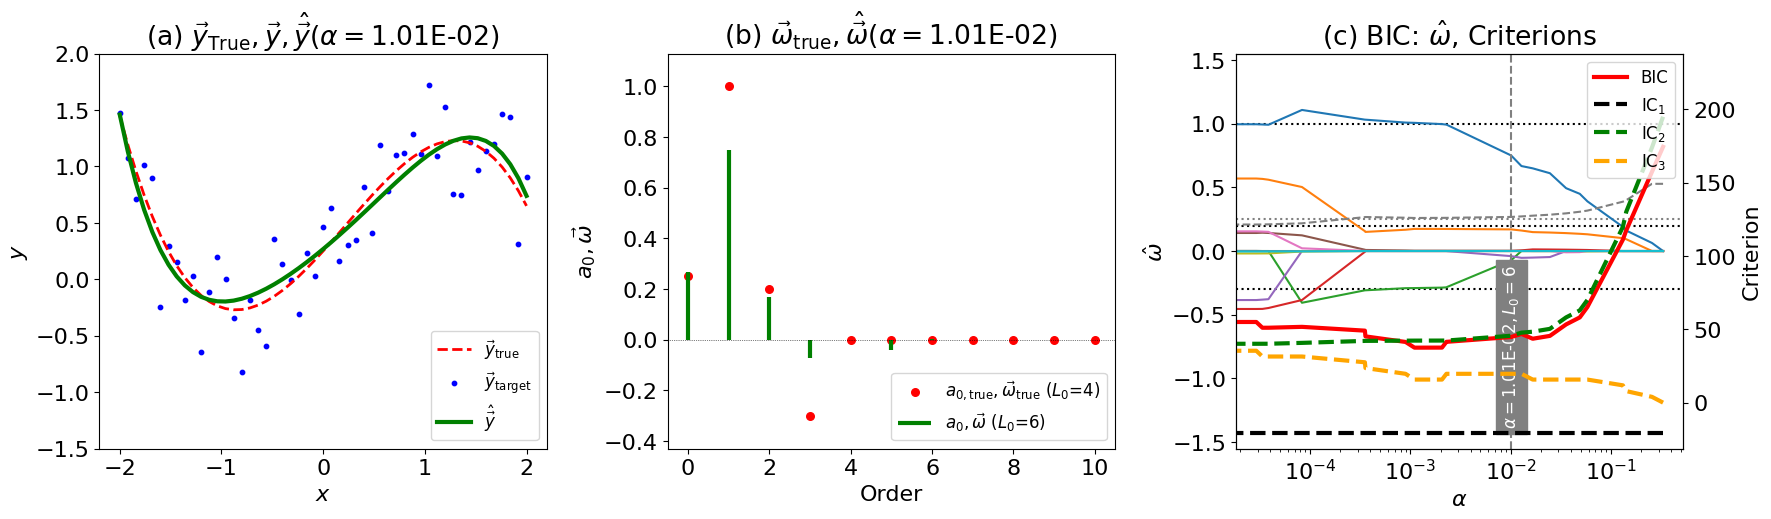

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-010-summary-01.pdf


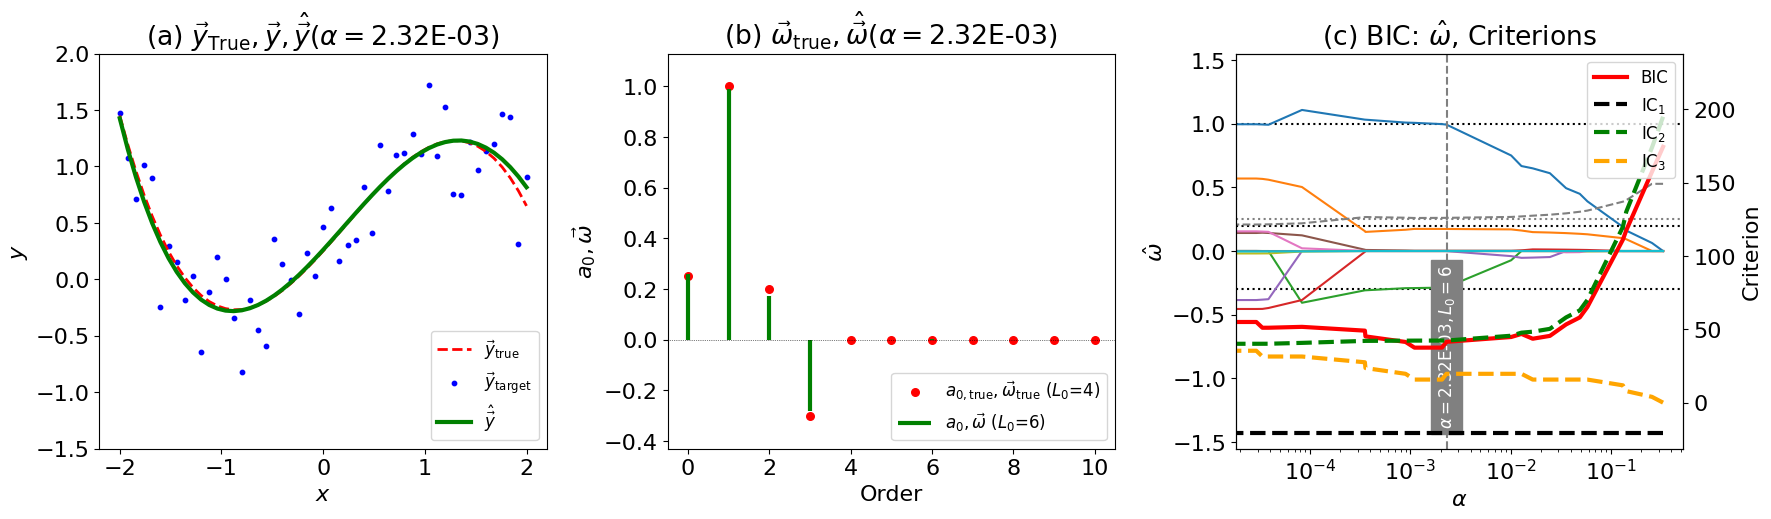

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-011-summary-01.pdf


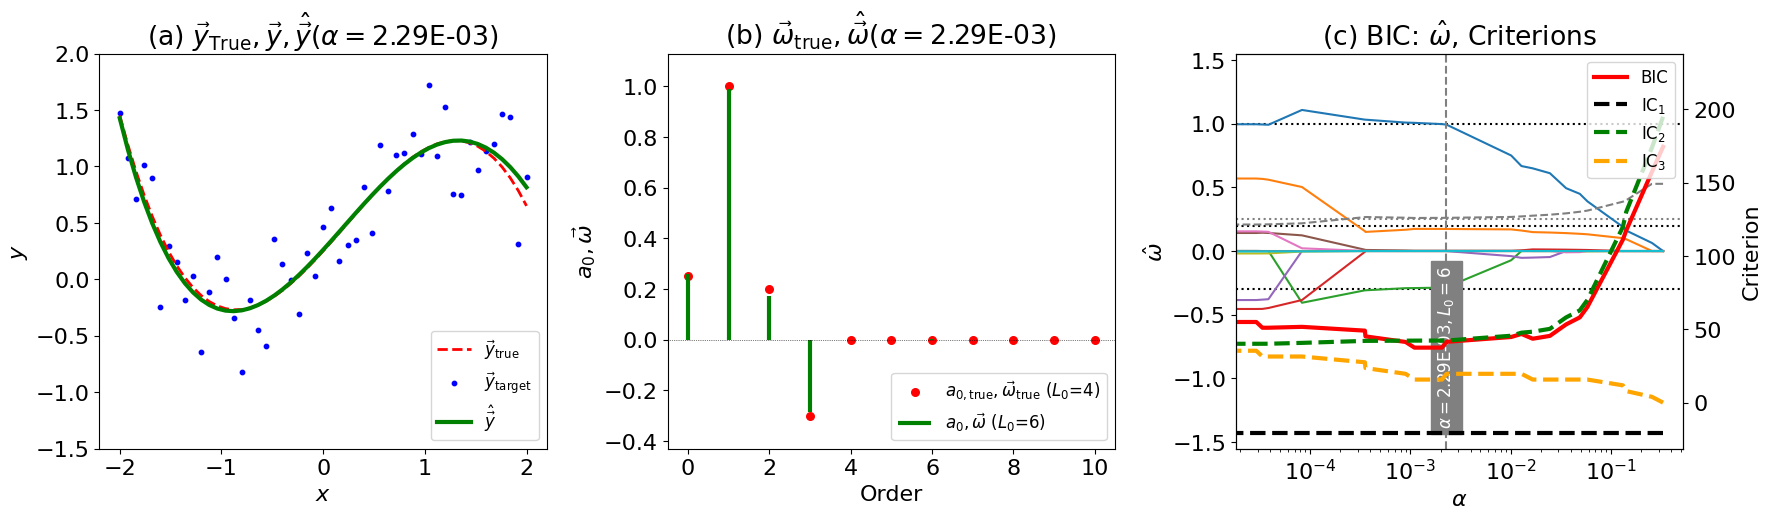

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-012-summary-01.pdf


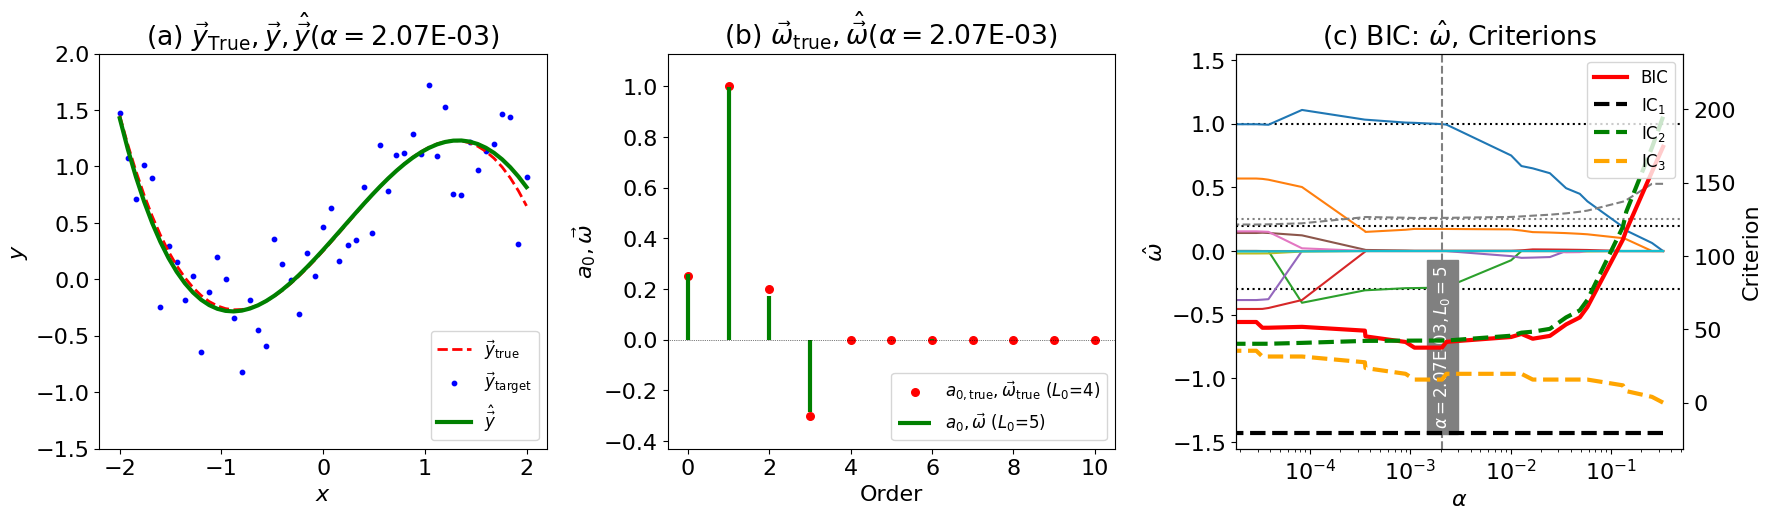

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-013-summary-01.pdf


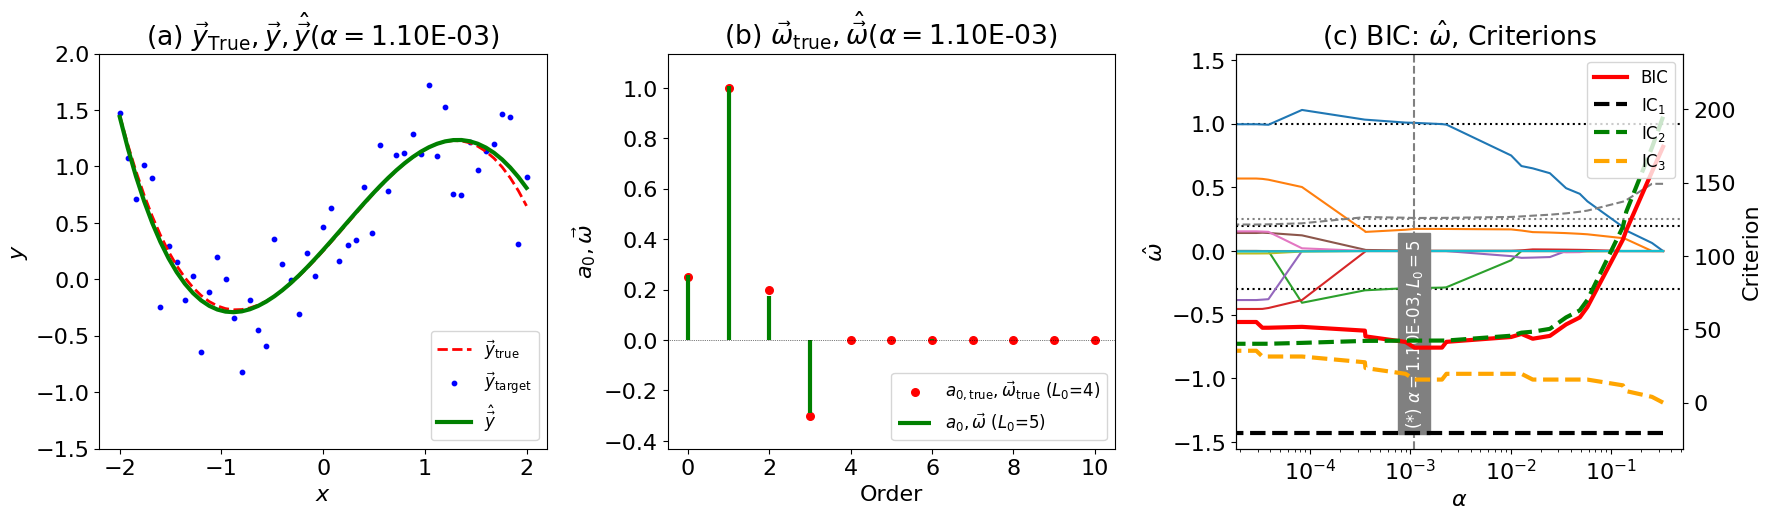

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-014-summary-01.pdf


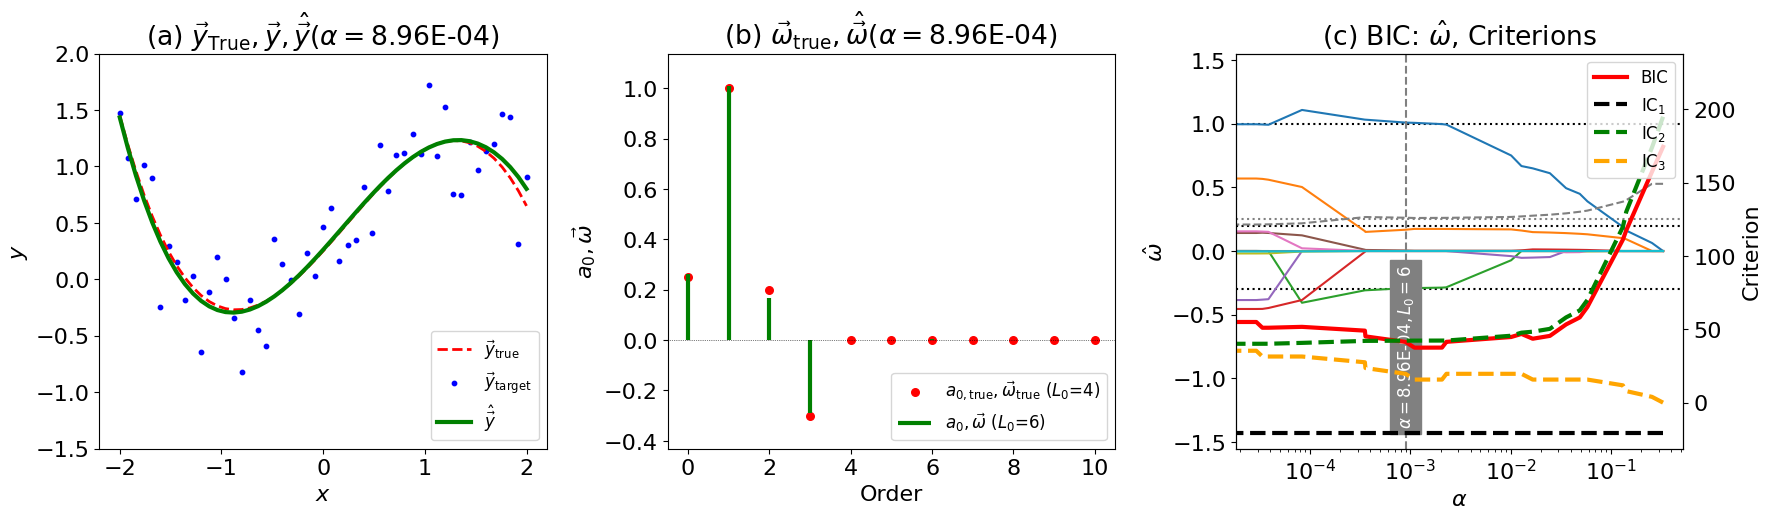

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-015-summary-01.pdf


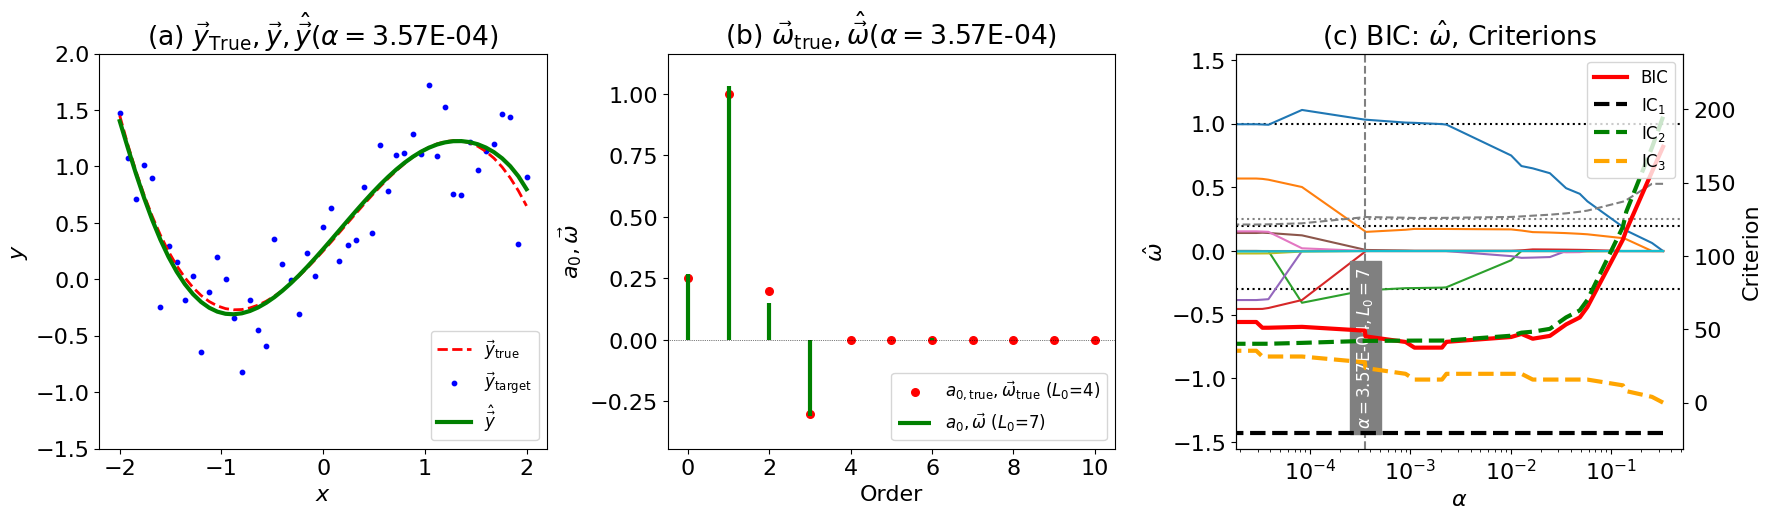

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-016-summary-01.pdf


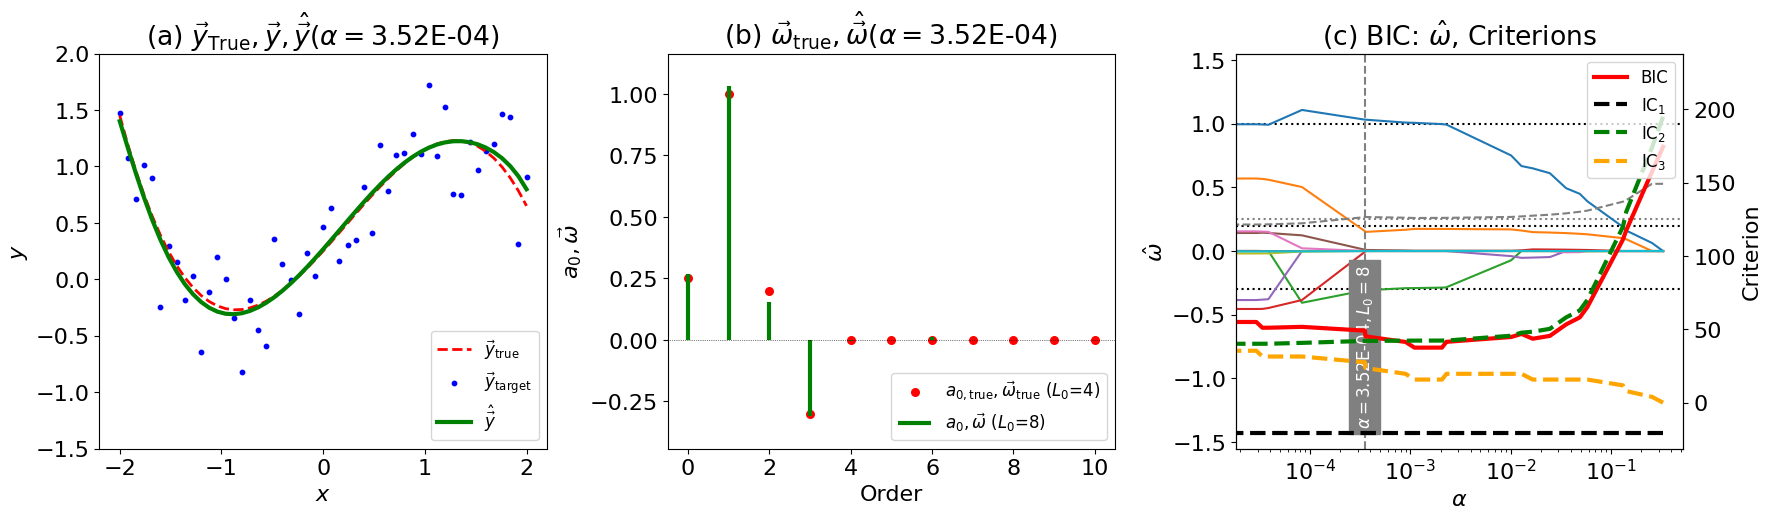

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-017-summary-01.pdf


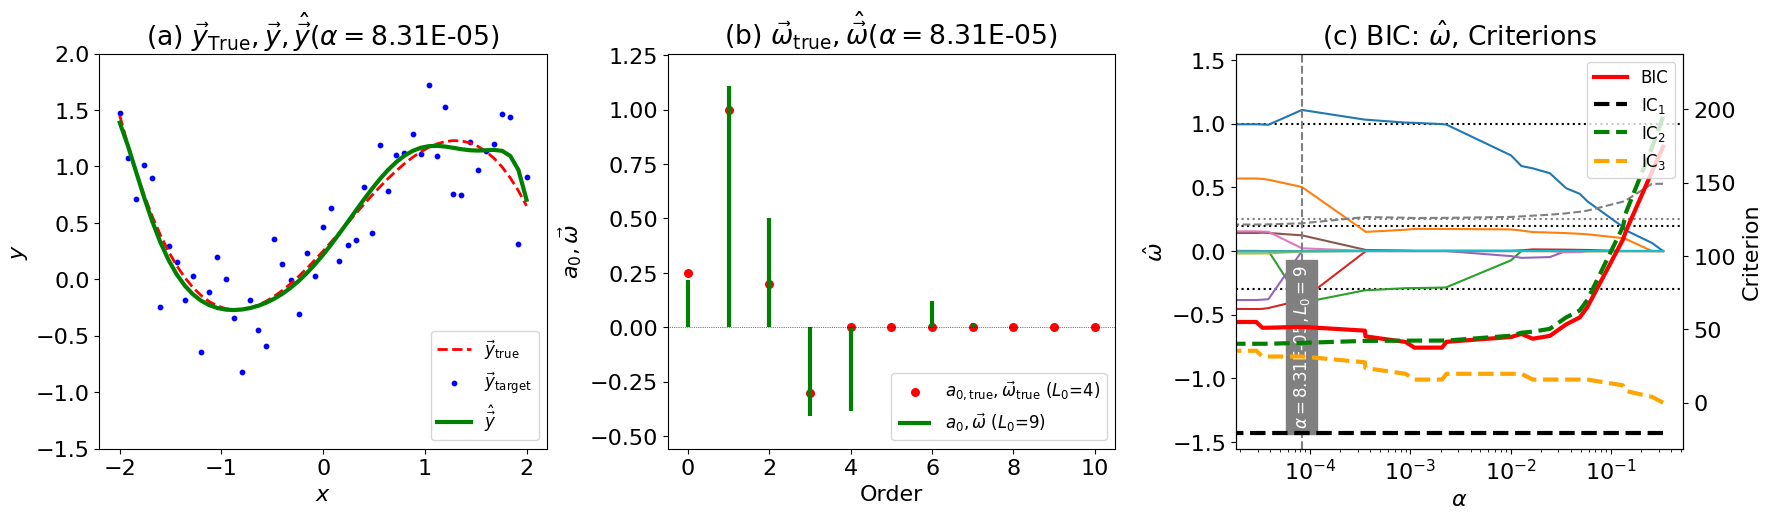

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-018-summary-01.pdf


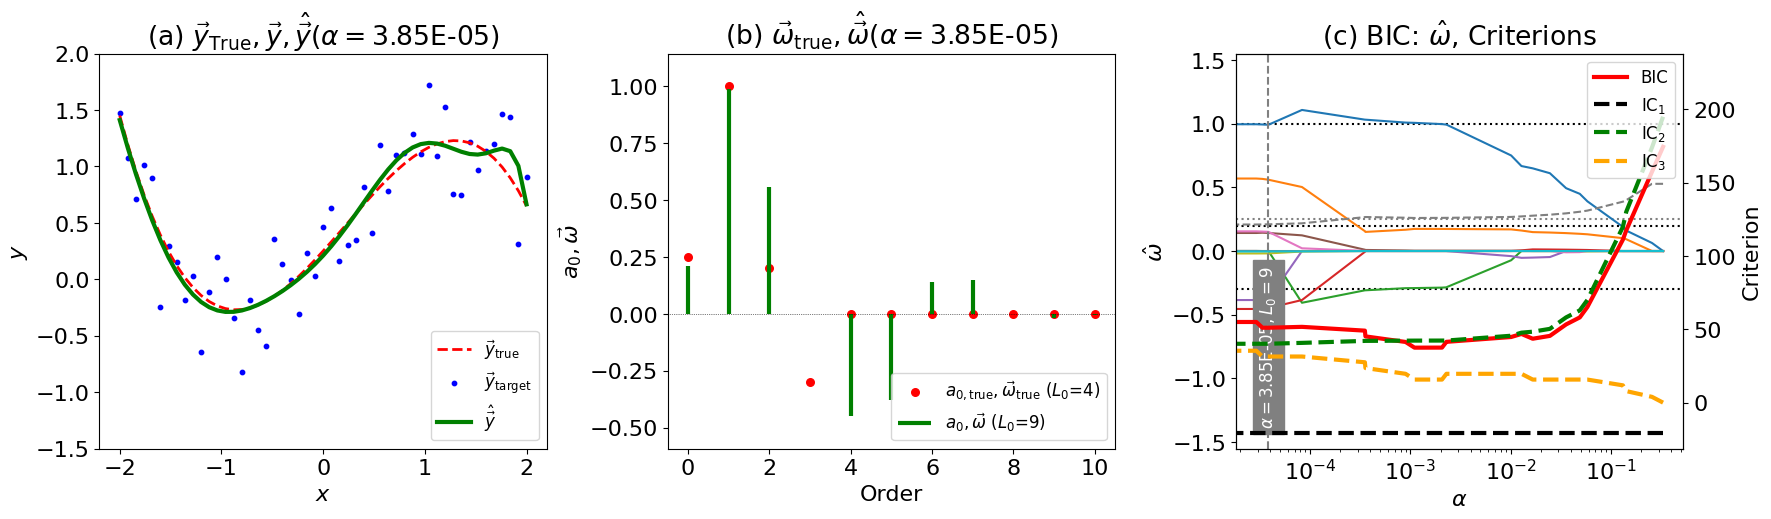

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-019-summary-01.pdf


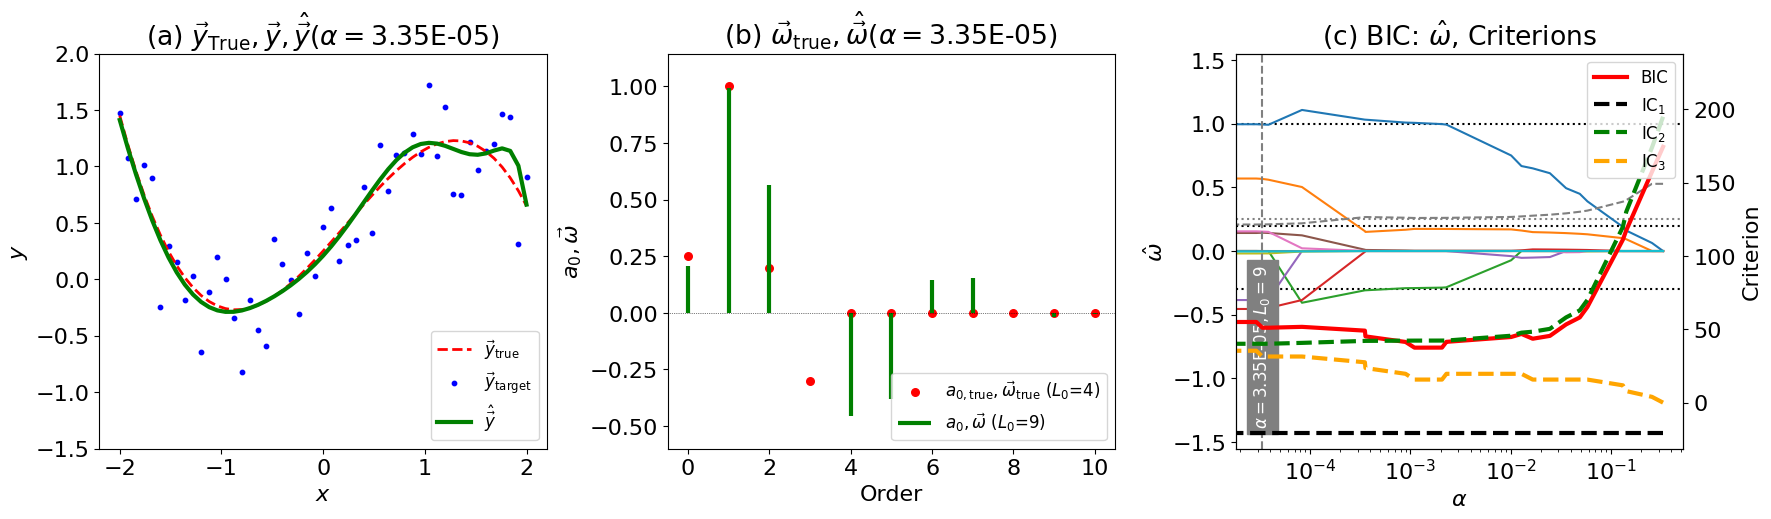

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-020-summary-01.pdf


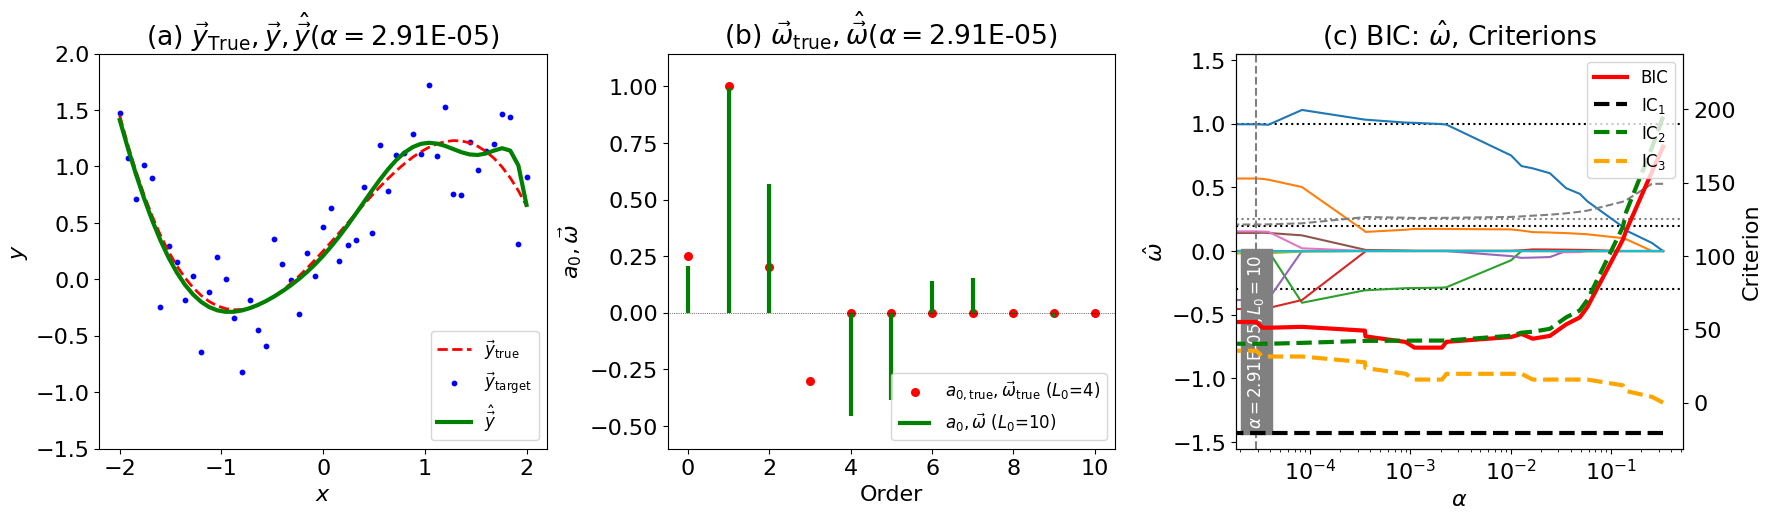

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-021-summary-01.pdf


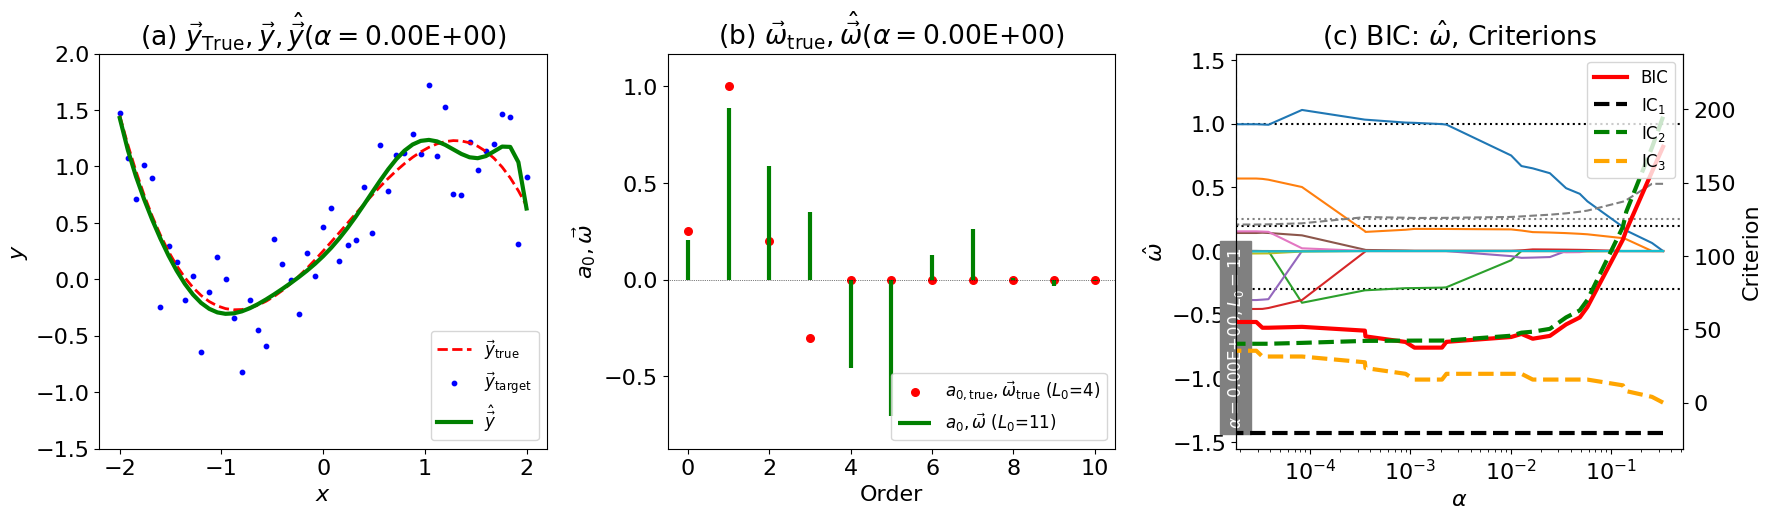

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3LassoLarsIC-0805Polynomial/3LassoLarsIC-0805Polynomial-BIC-022-summary-01.pdf


In [29]:
############################################
IC_upper_ = dictBICsurvey[ 'IC_upper' ]
alphas_   = dictBICsurvey[ 'alphas'   ]
#
for idx_ in range( len( alphas_ ) ):
  #
  fig = Grf_ICsurveySummary( dictBICsurvey, idx_=idx_ )
  #
  #
  pdfFName = FilePath + FileBaseName + '-' + IC_upper_ + '-%03d-summary-01.pdf' % idx_
  print( pdfFName )
  fig.savefig( pdfFName )